## Time series forecasting

Dataset: [Madrid weather dataset hourly 2019-2022](https://www.kaggle.com/datasets/rober2598/madrid-weather-dataset-by-hours-20192022/data)


Podaci sa meteorološke stanice Moratalaz u Madridu za period januar 2019-januar 2022.

Atributi:

1. temperature (ºC)
2. wind speed (m/s)
3. wind direction (in degrees)
4. humidity (%)
5. barometric pressure (mb)
6. solar radiation (W/m^2)
7. precipitation (l/m^2)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')
tf.random.set_seed(13)

### Učitavanje i priprema podataka

In [152]:
data = pd.read_csv("weather_madrid_2019-2022.csv", index_col=1)

In [153]:
data.index = pd.to_datetime(data.index)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27024 entries, 2019-01-01 00:59:59 to 2022-01-31 23:59:59
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           27024 non-null  int64  
 1   temperature          27024 non-null  float64
 2   wind_speed           27024 non-null  float64
 3   wind_direction       27024 non-null  float64
 4   humidity             27024 non-null  float64
 5   barometric_pressure  27024 non-null  float64
 6   solar_radiation      27024 non-null  float64
 7   precipitation        27024 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.9 MB


In [5]:
print(f"Number of missing values in dataset:\n{data.isna().sum()}")

Number of missing values in dataset:
Unnamed: 0             0
temperature            0
wind_speed             0
wind_direction         0
humidity               0
barometric_pressure    0
solar_radiation        0
precipitation          0
dtype: int64


In [6]:
data.head()

Unnamed: 0  temperature  wind_speed  wind_direction  \
time                                                                       
2019-01-01 00:59:59           0          3.1        0.65            64.0   
2019-01-01 01:59:59           1          2.9        0.95            32.0   
2019-01-01 02:59:59           2          3.1        0.87            62.0   
2019-01-01 03:59:59           3          1.9        0.73            75.0   
2019-01-01 04:59:59           4          0.7        0.57            53.0   

                     humidity  barometric_pressure  solar_radiation  \
time                                                                  
2019-01-01 00:59:59      50.0                949.0              0.0   
2019-01-01 01:59:59      49.0                949.0              0.0   
2019-01-01 02:59:59      46.0                949.0              0.0   
2019-01-01 03:59:59      51.0                949.0              0.0   
2019-01-01 04:59:59      56.0                949.0              0.0   

                     precipitation  
time                                
2019-01-01 00:59:59            0.0  
2019-01-01 01:59:59            0.0  
2019-01-01 02:59:59            0.0  
2019-01-01 03:59:59            0.0  
2019-01-01 04:59:59            0.0

In [154]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
data.head()

temperature  wind_speed  wind_direction  humidity  \
time                                                                     
2019-01-01 00:59:59          3.1        0.65            64.0      50.0   
2019-01-01 01:59:59          2.9        0.95            32.0      49.0   
2019-01-01 02:59:59          3.1        0.87            62.0      46.0   
2019-01-01 03:59:59          1.9        0.73            75.0      51.0   
2019-01-01 04:59:59          0.7        0.57            53.0      56.0   

                     barometric_pressure  solar_radiation  precipitation  
time                                                                      
2019-01-01 00:59:59                949.0              0.0            0.0  
2019-01-01 01:59:59                949.0              0.0            0.0  
2019-01-01 02:59:59                949.0              0.0            0.0  
2019-01-01 03:59:59                949.0              0.0            0.0  
2019-01-01 04:59:59                949.0              0.0            0.0

In [9]:
data.tail()

temperature  wind_speed  wind_direction  humidity  \
time                                                                     
2022-01-31 19:59:59         10.1        2.65            47.0      17.0   
2022-01-31 20:59:59          8.2        3.82            21.0      25.0   
2022-01-31 21:59:59          7.2        2.38            29.0      31.0   
2022-01-31 22:59:59          5.6        3.92            58.0      41.0   
2022-01-31 23:59:59          4.9        3.95            11.0      47.0   

                     barometric_pressure  solar_radiation  precipitation  
time                                                                      
2022-01-31 19:59:59                946.0              0.0            0.0  
2022-01-31 20:59:59                947.0              0.0            0.0  
2022-01-31 21:59:59                947.0              0.0            0.0  
2022-01-31 22:59:59                947.0              0.0            0.0  
2022-01-31 23:59:59                948.0              0.0            0.0

In [10]:
data.describe()

temperature    wind_speed  wind_direction      humidity  \
count  27024.000000  27024.000000    27024.000000  27024.000000   
mean      12.817040      2.058503      142.523313     54.560909   
std        8.195516      1.253231       92.795447     22.700106   
min       -9.100000      0.000000        0.000000      0.000000   
25%        6.400000      1.100000       62.000000     36.000000   
50%       11.400000      1.800000      122.000000     53.000000   
75%       18.800000      2.770000      241.000000     72.000000   
max       37.900000      9.450000      359.000000    100.000000   

       barometric_pressure  solar_radiation  precipitation  
count         27024.000000     27024.000000   27024.000000  
mean            940.013433       197.641282       0.045811  
std              17.668038       284.877404       0.463671  
min               0.000000         0.000000       0.000000  
25%             938.000000         0.000000       0.000000  
50%             941.000000         9.000000       0.000000  
75%             944.000000       355.000000       0.000000  
max             952.000000      1068.000000      27.400000

In [11]:
data.skew()

temperature             0.461747
wind_speed              1.008883
wind_direction          0.248713
humidity                0.152653
barometric_pressure   -29.898869
solar_radiation         1.311261
precipitation          30.785920
dtype: float64

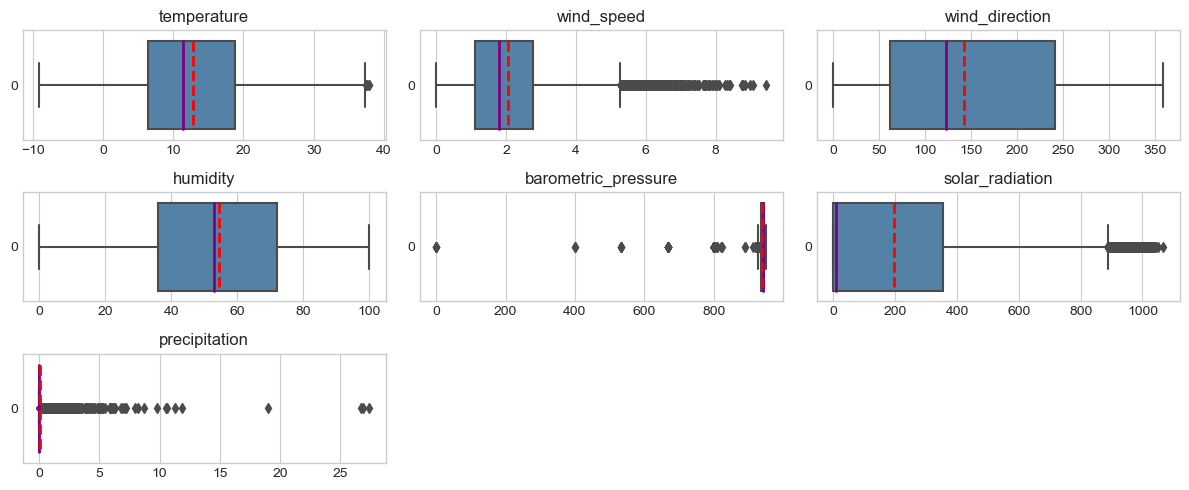

In [12]:
plt.figure(figsize=(12, 5))
for i, feature in enumerate(list(data.columns)):
    plt.subplot(3, 3, i+1)
    plt.title(feature)
    sns.boxplot(data[feature], orient='h', color="steelblue", showmeans=True, meanline=True,
                    medianprops={'linewidth': 2, 'color': 'purple'},
                    meanprops={'linewidth': 2, 'color': 'red'})
plt.tight_layout()

In [155]:
Q1 = data['barometric_pressure'].quantile(0.25)
Q3 = data['barometric_pressure'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

upper_array = data[data['barometric_pressure'] >= upper].index
lower_array = data[data['barometric_pressure'] <= lower].index

mean = data.loc[:, 'barometric_pressure'].mean()
data.loc[upper_array, 'barometric_pressure'] = mean
data.loc[lower_array, 'barometric_pressure'] = mean

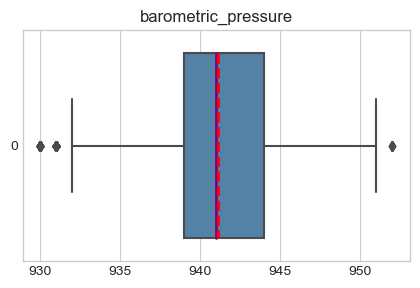

In [14]:
plt.figure(figsize=(5, 3))
plt.title("barometric_pressure")
sns.boxplot(data["barometric_pressure"], orient='h', color="steelblue", showmeans=True, meanline=True,
                    medianprops={'linewidth': 2, 'color': 'purple'},
                    meanprops={'linewidth': 2, 'color': 'red'})
plt.show()

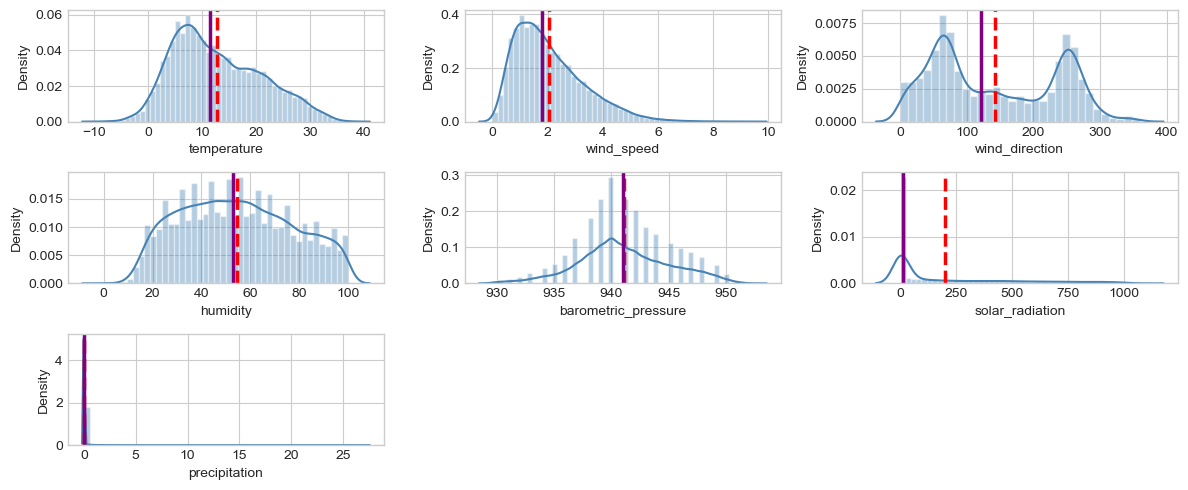

In [15]:
plt.figure(figsize=(12, 5))
for i, feature in enumerate(list(data.columns)):
    plt.subplot(3, 3, i+1)
    sns.distplot(data[feature], color="steelblue")
    plt.axvline(x=data[feature].mean(), c='red', ls='--', lw=2.5)
    plt.axvline(x=data[feature].median(), c='purple', ls='-', lw=2.5)
plt.tight_layout()

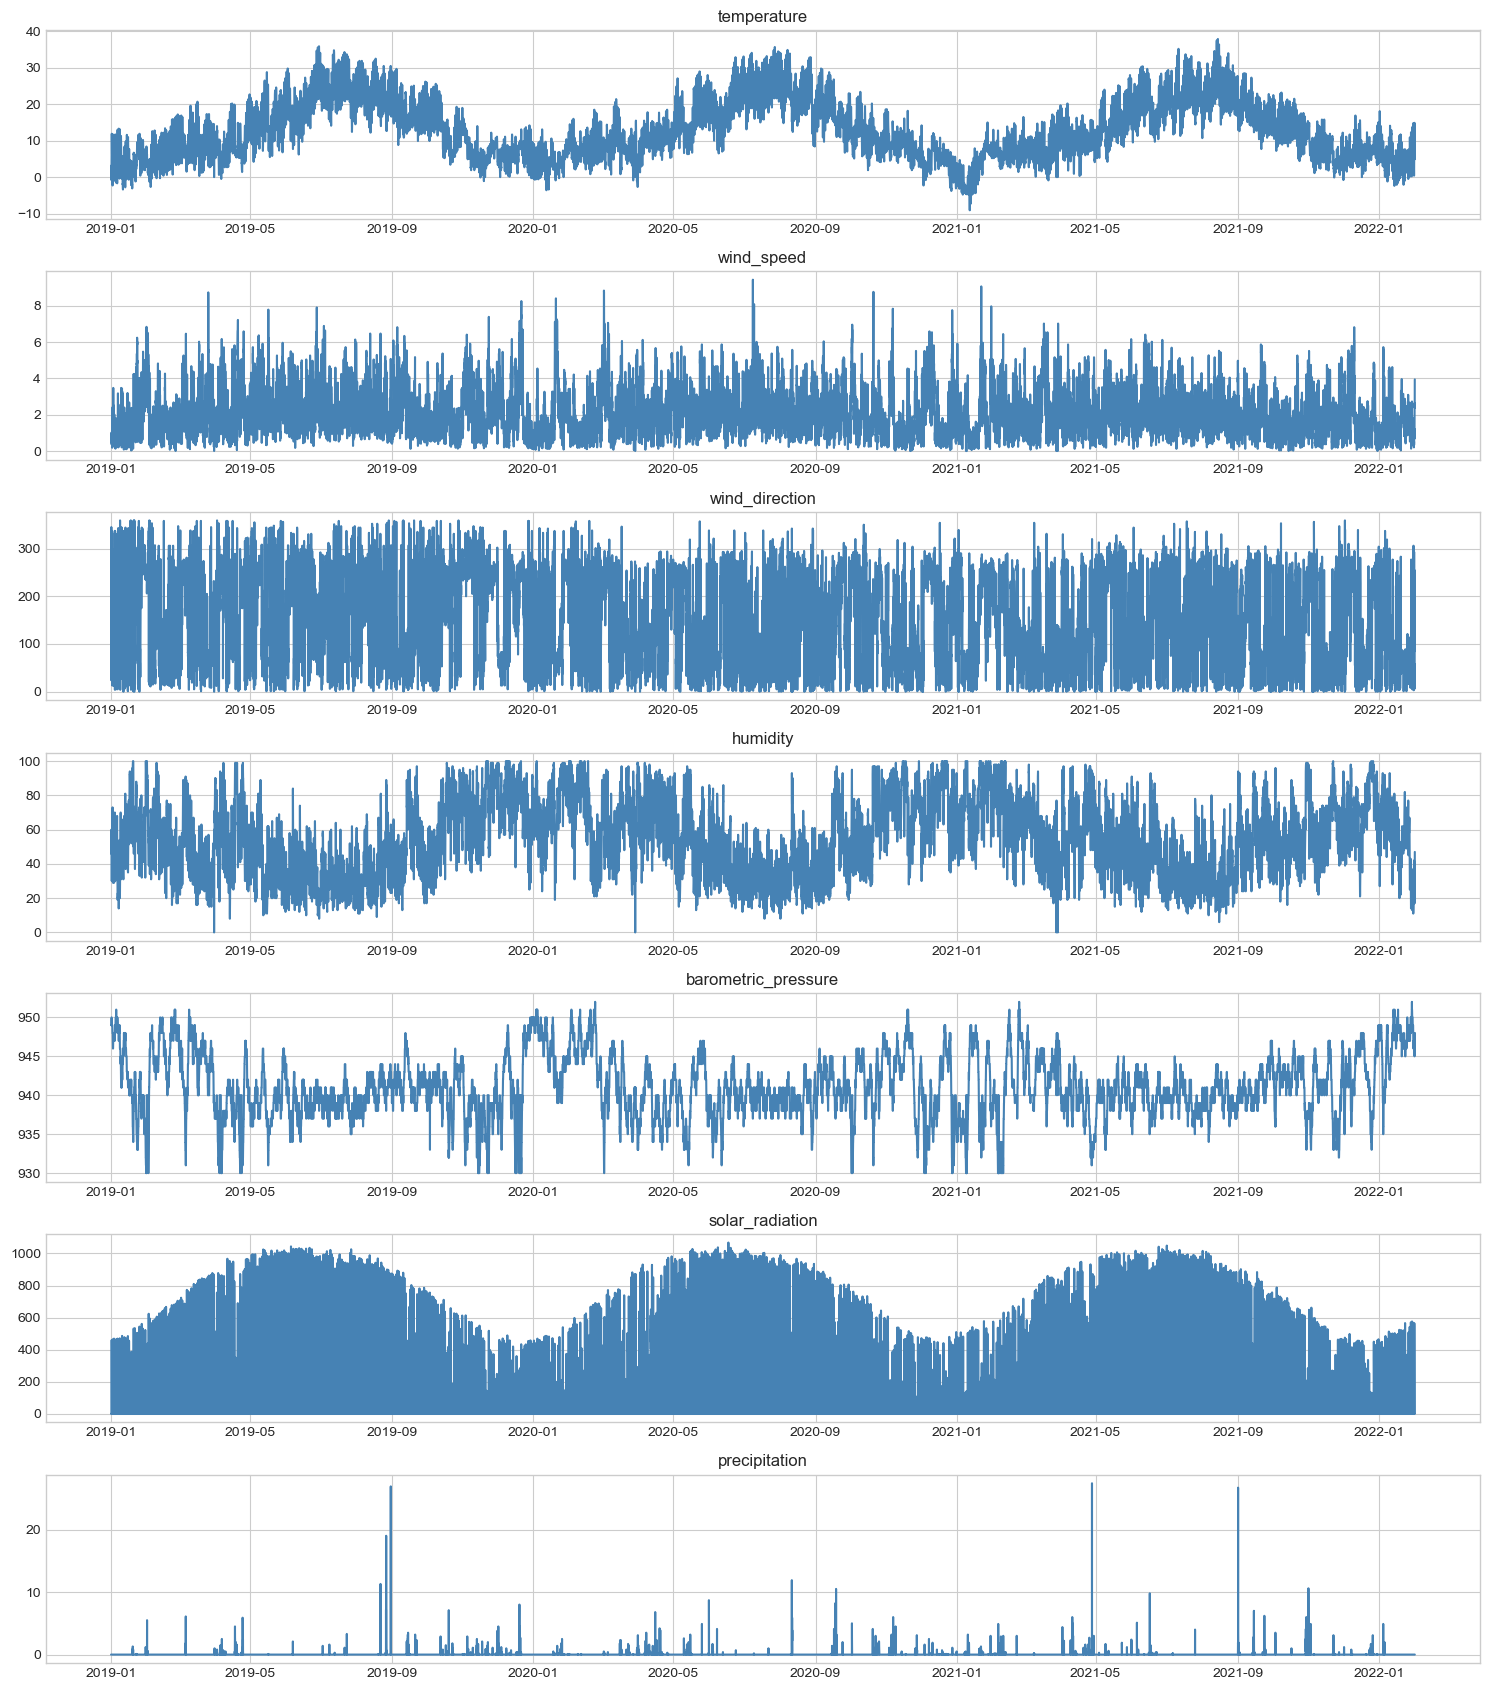

In [16]:
plt.figure(figsize=(15, 17))
for i, feature in enumerate(list(data.columns)):
    plt.subplot(7, 1, i+1)
    plt.title(feature)
    plt.plot(data.index, data[feature].values, color="steelblue")
plt.tight_layout()

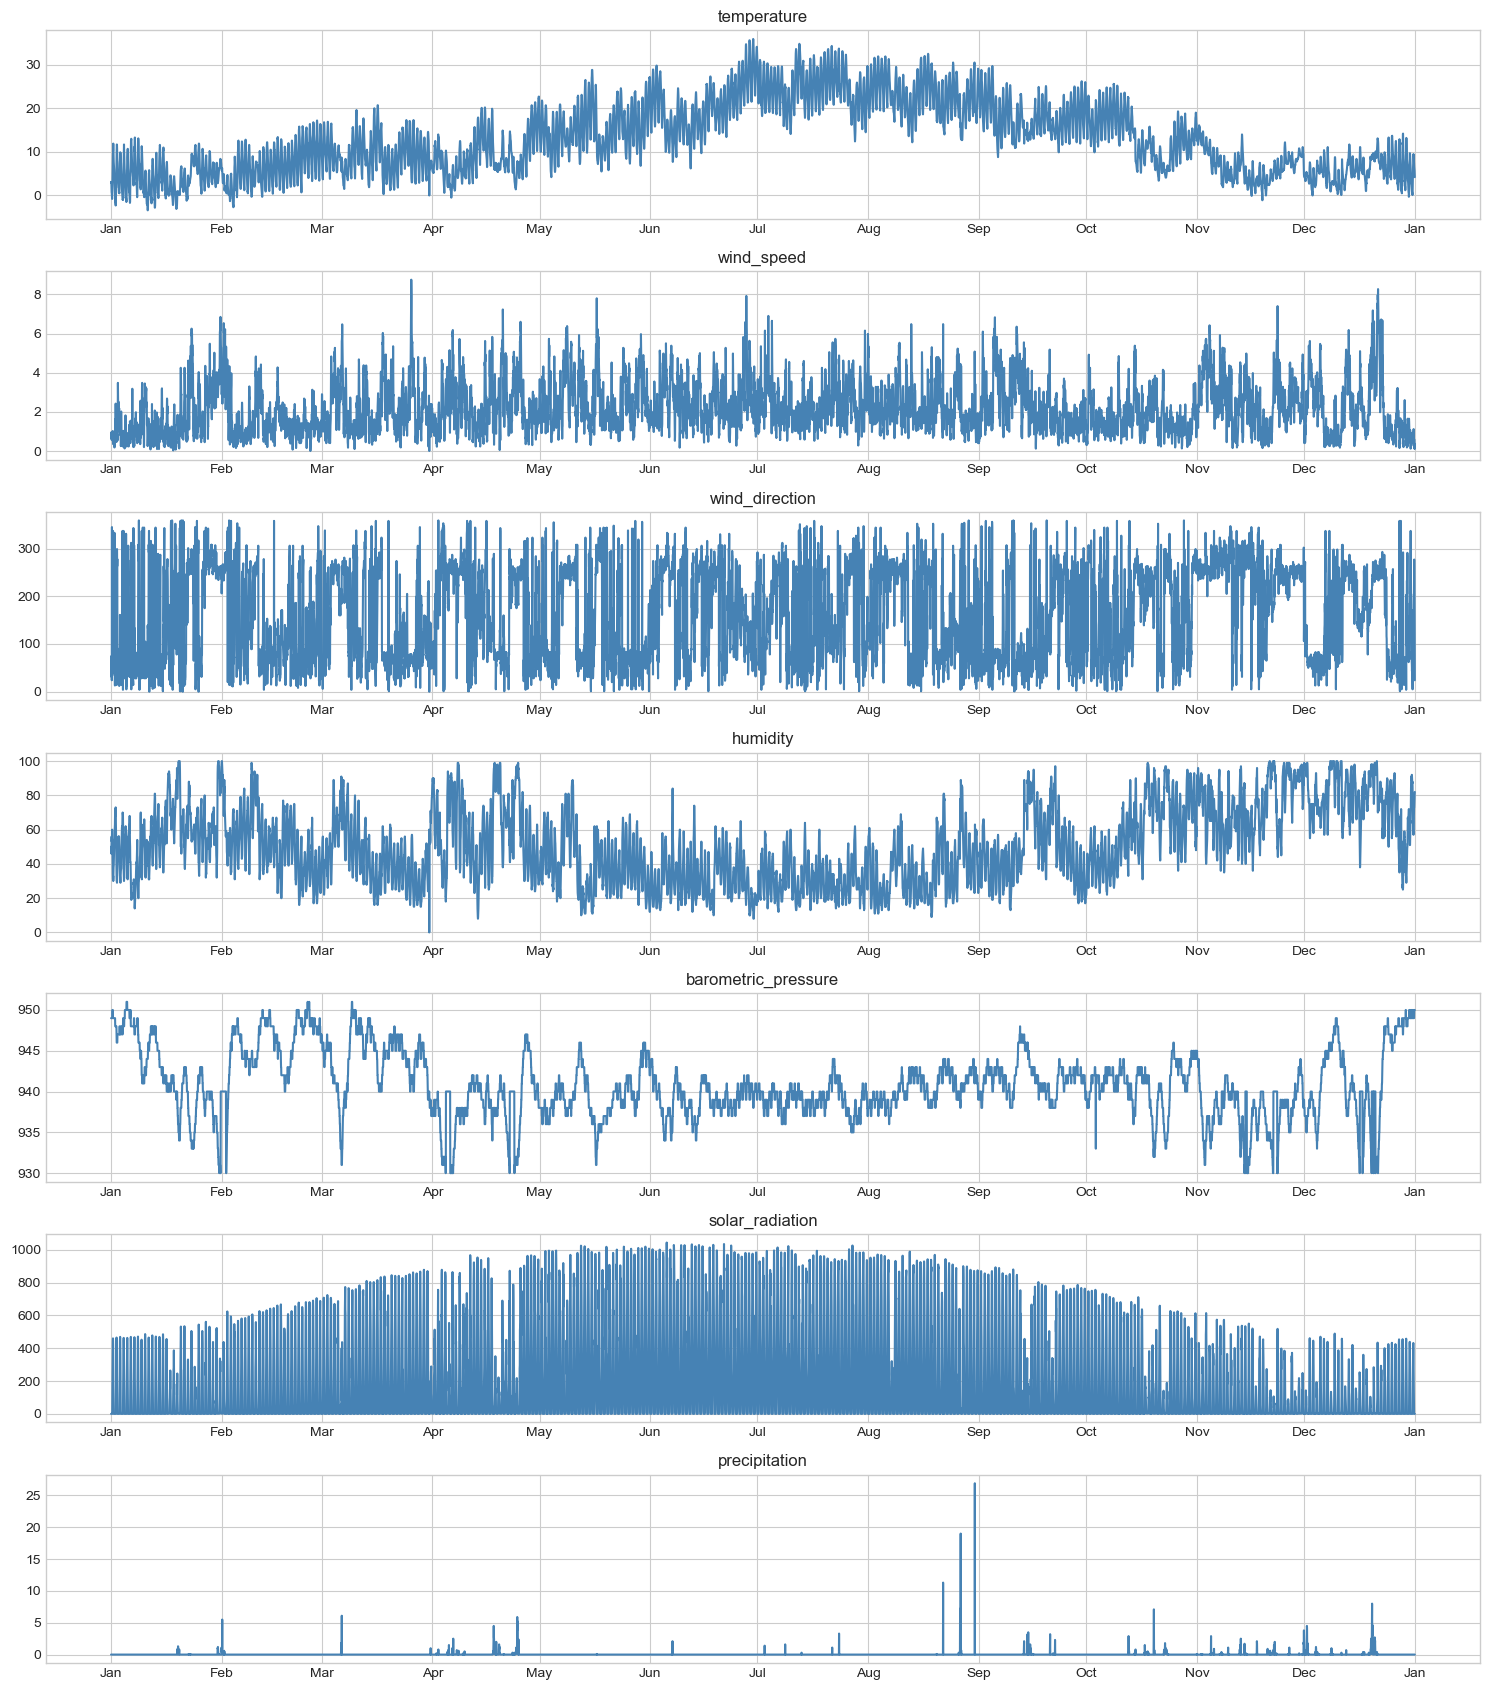

In [17]:
plt.figure(figsize=(15, 17))
for i, feature in enumerate(list(data.columns)):
    ax = plt.subplot(7, 1, i+1)
    plt.title(feature)
    plt.plot(list(data.index.values[0:365*24]), data[feature].values[0:365*24], color="steelblue")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()

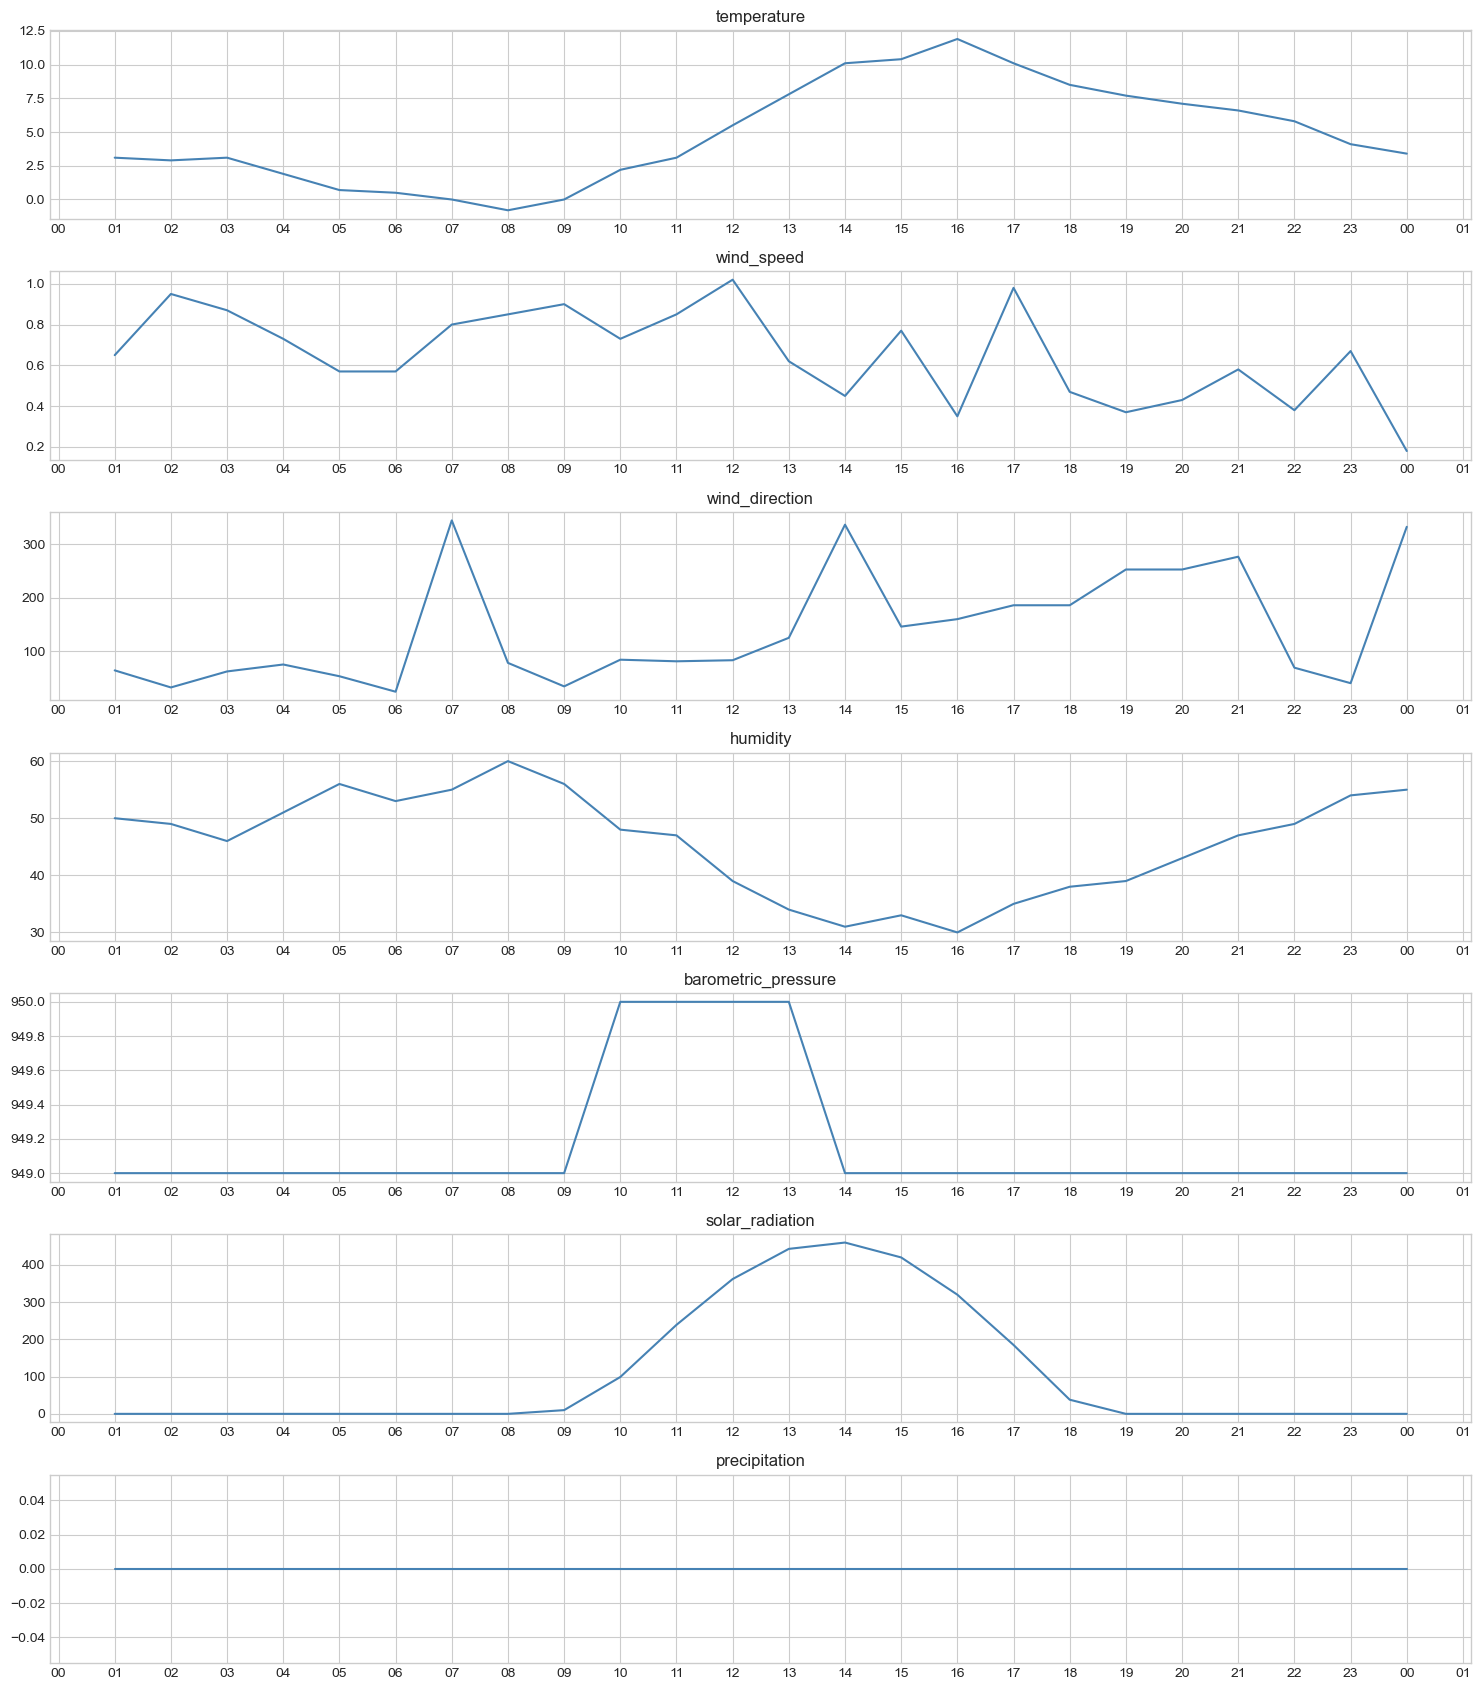

In [160]:
plt.figure(figsize=(15, 17))
for i, feature in enumerate(list(data.columns)):
    ax = plt.subplot(7, 1, i+1)
    plt.title(feature)
    plt.plot(list(data.index.values[0:24]), data[feature].values[0:24], color="steelblue")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.tight_layout()

Transformacija smera i brzine vetra u vektor:

In [162]:
wv = data.pop('wind_speed')
wd_rad = data.pop('wind_direction')*np.pi / 180

data['wind_x'] = wv*np.cos(wd_rad)
data['wind_y'] = wv*np.sin(wd_rad)

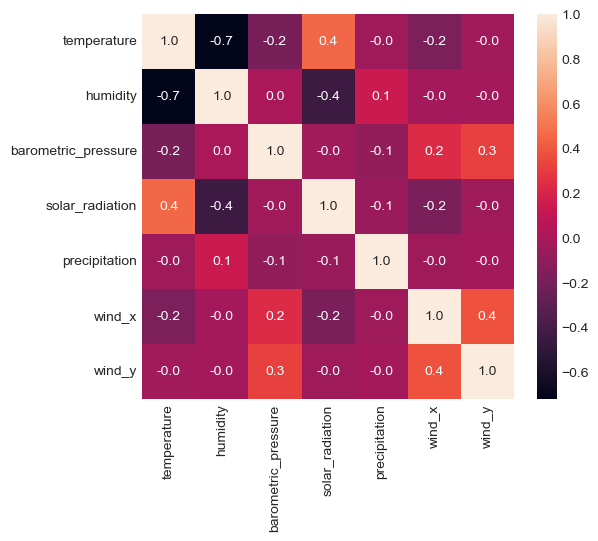

In [164]:
plt.figure(figsize=(6, 5))
sns.heatmap(data.corr(), annot = True, fmt='.1f')
plt.show()

In [165]:
data.drop(["precipitation", "wind_y"], axis=1, inplace=True)

In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27024 entries, 2019-01-01 00:59:59 to 2022-01-31 23:59:59
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperature          27024 non-null  float64
 1   humidity             27024 non-null  float64
 2   barometric_pressure  27024 non-null  float64
 3   solar_radiation      27024 non-null  float64
 4   wind_x               27024 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


### Helpers

In [21]:
def series_to_supervised(data, index, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    df.index = index
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [22]:
def prepare_dataset(reframed):
    values = reframed.values
    n_train_hours = 2 * 365 * 24

    values_min = values.min(axis=0)
    values_max = values.max(axis=0)
    values = (values - values_min)/(values_max - values_min)

    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]

    train_X, train_y = train[:, :-1], train[:, -1]
    train_y = train_y.reshape((len(train_y), 1))
    inv_train_y = train_y * (values_max[-1] - values_min[-1]) + values_min[-1]

    new_n_train_hours = n_train_hours - 3 * 30 * 24
    val = train[new_n_train_hours:, :]
    train = train[:new_n_train_hours, :]

    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    val_X, val_y = val[:, :-1], val[:, -1]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))

    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

    ret_val = {"train_X": train_X,
               "train_y": train_y,
               "test_X": test_X,
               "test_y": test_y,
               "val_X": val_X,
               "val_y": val_y,
               "inv_train_y": inv_train_y,
               "values_min": values_min,
               "values_max": values_max,
               "n_train_hours": n_train_hours}

    return ret_val

In [23]:
def get_callbacks():
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
    callbacks = [early_stopping, model_checkpoint]

    return callbacks

In [24]:
def train_SimpleRNN_model(train_X, train_y, val_X, val_y, optimizer, loss):
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optimizer)
    history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, 
                        shuffle=False, callbacks=get_callbacks())

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    return model

In [25]:
def train_LSTM_model(train_X, train_y, val_X, val_y, optimizer, loss):
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optimizer)
    history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, 
                        shuffle=False, callbacks=get_callbacks())

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    return model

In [26]:
def train_GRU_model(train_X, train_y, val_X, val_y, optimizer, loss):
    model = Sequential()
    model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optimizer)
    history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, shuffle=False, callbacks=get_callbacks())

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    return model

In [27]:
def calculate_metrics(inv_y, inv_pred_y):
    mae = mean_absolute_error(inv_y, inv_pred_y)
    mse = mean_squared_error(inv_y, inv_pred_y)
    rmse = math.sqrt(mean_squared_error(inv_y, inv_pred_y))
    r2 = r2_score(inv_y, inv_pred_y)

    print('Test MAE: %.3f' % mae)
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print('Test R2: %.3f' % r2)

    return [mae, mse, rmse, r2]

In [28]:
def evaluate_model(model, values_min, values_max, test_X, test_y):
    pred_y = model.predict(test_X)

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = test_y * (values_max[-1] - values_min[-1]) + values_min[-1]
    pred_y = pred_y.reshape((len(pred_y), 1))
    inv_pred_y = pred_y * (values_max[-1] - values_min[-1]) + values_min[-1]

    metrics = calculate_metrics(inv_y, inv_pred_y)
    ret_val = {"inv_y": inv_y, "inv_pred_y": inv_pred_y, "metrics": metrics}

    return ret_val

In [29]:
def visualize_predictions(time, n_train_hours, train_y, test_y, pred_y):
    plt.figure(figsize=(15, 15))

    plt.subplot(3, 1, 1)
    plt.title("Train + Test")
    plt.plot(time[:n_train_hours], train_y, label = "train_data", color = "b")
    plt.plot(time[n_train_hours:], pred_y, label = "test_data", color = "g")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("True vs Predicted")
    plt.plot(time[n_train_hours:], test_y, label = "true", color = "g")
    plt.plot(time[n_train_hours:], pred_y, label = "predicted", color = "r")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("True vs Predicted")
    plt.plot(time[n_train_hours:n_train_hours+10*24], test_y[:10*24], label = "true", color = "g")
    plt.plot(time[n_train_hours:n_train_hours+10*24], pred_y[:10*24], label = "predicted", color = "r")
    plt.legend()

    plt.show()

### Univariate forecasting

In [167]:
reframed = series_to_supervised(data[['temperature']], data.index, 5, 1)

In [168]:
reframed.head()

var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  \
time                                                                         
2019-01-01 05:59:59        3.1        2.9        3.1        1.9        0.7   
2019-01-01 06:59:59        2.9        3.1        1.9        0.7        0.5   
2019-01-01 07:59:59        3.1        1.9        0.7        0.5        0.0   
2019-01-01 08:59:59        1.9        0.7        0.5        0.0       -0.8   
2019-01-01 09:59:59        0.7        0.5        0.0       -0.8        0.0   

                     var1(t)  
time                          
2019-01-01 05:59:59      0.5  
2019-01-01 06:59:59      0.0  
2019-01-01 07:59:59     -0.8  
2019-01-01 08:59:59      0.0  
2019-01-01 09:59:59      2.2

In [32]:
prepared_data = prepare_dataset(reframed)

(15360, 1, 5) (15360,) (9499, 1, 5) (9499,) (2160, 1, 5) (2160,)


#### SimpleRNN

##### Optimizer: Adam, Loss: MSE


Epoch 1/50

240/240 - 3s - loss: 8.7937e-04 - val_loss: 3.1477e-04 - 3s/epoch - 11ms/step
Epoch 2/50
240/240 - 0s - loss: 6.0147e-04 - val_loss: 3.1103e-04 - 475ms/epoch - 2ms/step
Epoch 3/50
240/240 - 0s - loss: 5.6179e-04 - val_loss: 3.0604e-04 - 463ms/epoch - 2ms/step
Epoch 4/50
240/240 - 0s - loss: 5.3386e-04 - val_loss: 2.9944e-04 - 458ms/epoch - 2ms/step
Epoch 5/50
240/240 - 0s - loss: 5.0924e-04 - val_loss: 2.9582e-04 - 472ms/epoch - 2ms/step
Epoch 6/50
240/240 - 0s - loss: 4.8714e-04 - val_loss: 2.9646e-04 - 438ms/epoch - 2ms/step
Epoch 7/50
240/240 - 0s - loss: 4.6721e-04 - val_loss: 3.0140e-04 - 443ms/epoch - 2ms/step
Epoch 8/50
240/240 - 0s - loss: 4.4919e-04 - val_loss: 3.0948e-04 - 489ms/epoch - 2ms/step
Epoch 9/50
240/240 - 0s - loss: 4.3283e-04 - val_loss: 3.1868e-04 - 460ms/epoch - 2ms/step
Epoch 10/50
240/240 - 0s - loss: 4.1789e-04 - val_loss: 3.2705e-04 - 461ms/epoch - 2ms/step
Epoch 11/50
240/240 - 0s - loss: 4.0420e-04 - val_loss: 3.3337e-04 - 447ms/epoch - 2ms/st

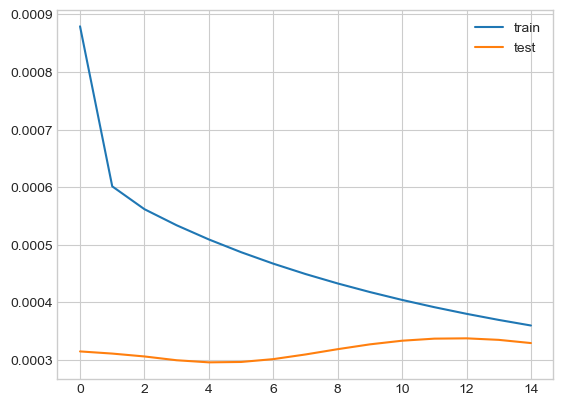

In [33]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mse')

In [34]:
simpleRNN_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adam_mse_metrics = ["Adam", "MSE"] + simpleRNN_adam_mse["metrics"]

297/297 [==============================] - 1s 1ms/step
Test MAE: 0.907
Test MSE: 1.441
Test RMSE: 1.200
Test R2: 0.978


##### Optimizer: Adam, Loss: MAE

Epoch 1/50
240/240 - 7s - loss: 0.0318 - val_loss: 0.0155 - 7s/epoch - 27ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0187 - val_loss: 0.0180 - 841ms/epoch - 4ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0178 - val_loss: 0.0192 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0171 - val_loss: 0.0176 - 1s/epoch - 5ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0165 - val_loss: 0.0166 - 979ms/epoch - 4ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0160 - val_loss: 0.0166 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0156 - val_loss: 0.0144 - 1s/epoch - 5ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0152 - val_loss: 0.0140 - 798ms/epoch - 3ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0148 - val_loss: 0.0133 - 948ms/epoch - 4ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0144 - val_loss: 0.0113 - 1s/epoch - 6ms/step
Epoch 11/50
240/240 - 1s - loss: 0.0140 - val_loss: 0.0126 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 1s - loss: 0.0138 - val_loss: 0.0120 - 1s/epoch - 6ms/step
Epoch 13/50
240/240 - 1s

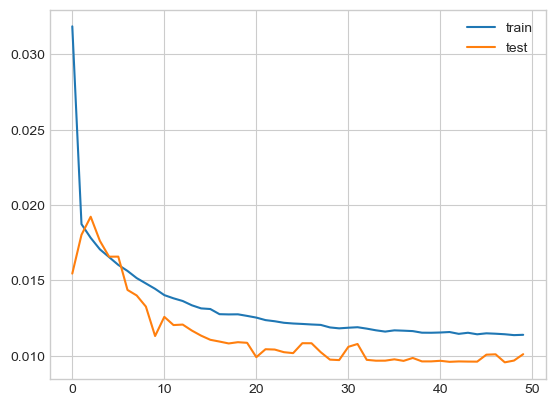

In [35]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mae')

In [36]:
simpleRNN_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adam_mae_metrics = ["Adam", "MAE"] + simpleRNN_adam_mae["metrics"]

297/297 [==============================] - 2s 5ms/step
Test MAE: 0.606
Test MSE: 0.693
Test RMSE: 0.832
Test R2: 0.990


##### Optimizer: Adam, Loss: MAPE

Epoch 1/50
240/240 - 6s - loss: 20.0520 - val_loss: 12.4198 - 6s/epoch - 27ms/step
Epoch 2/50
240/240 - 2s - loss: 5.7366 - val_loss: 4.8042 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 1s - loss: 3.9765 - val_loss: 4.1522 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 2s - loss: 3.7148 - val_loss: 4.0959 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 1s - loss: 3.5919 - val_loss: 3.7876 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 1s - loss: 3.4896 - val_loss: 3.5321 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 3.3965 - val_loss: 3.4865 - 1s/epoch - 5ms/step
Epoch 8/50
240/240 - 1s - loss: 3.2955 - val_loss: 3.1590 - 960ms/epoch - 4ms/step
Epoch 9/50
240/240 - 1s - loss: 3.2384 - val_loss: 3.1711 - 785ms/epoch - 3ms/step
Epoch 10/50
240/240 - 1s - loss: 3.2128 - val_loss: 3.0965 - 802ms/epoch - 3ms/step
Epoch 11/50
240/240 - 1s - loss: 3.1732 - val_loss: 2.9809 - 754ms/epoch - 3ms/step
Epoch 12/50
240/240 - 1s - loss: 3.1390 - val_loss: 3.0040 - 702ms/epoch - 3ms/step
Epoch 13/50
240/240

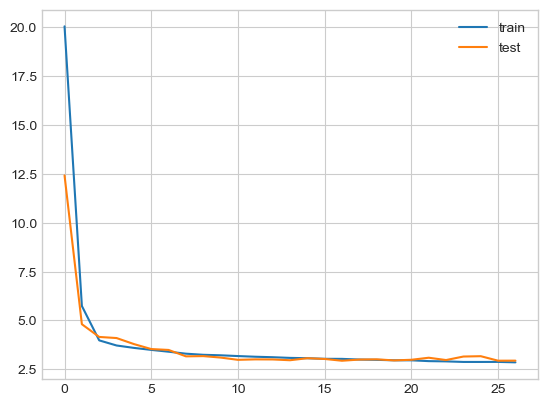

In [37]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mape')

In [38]:
simpleRNN_adam_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adam_mape_metrics = ["Adam", "MAPE"] + simpleRNN_adam_mape["metrics"]

297/297 [==============================] - 1s 3ms/step
Test MAE: 0.652
Test MSE: 0.782
Test RMSE: 0.884
Test R2: 0.988


##### Optimizer: SGD, Loss: MSE

Epoch 1/50
240/240 - 5s - loss: 0.0040 - val_loss: 0.0051 - 5s/epoch - 19ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0021 - val_loss: 0.0034 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0018 - val_loss: 0.0024 - 714ms/epoch - 3ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0016 - val_loss: 0.0018 - 1s/epoch - 6ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0014 - val_loss: 0.0015 - 1s/epoch - 5ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0013 - val_loss: 0.0013 - 1s/epoch - 4ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0012 - val_loss: 0.0012 - 960ms/epoch - 4ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0011 - val_loss: 0.0011 - 849ms/epoch - 4ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0011 - val_loss: 9.8592e-04 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0010 - val_loss: 9.3368e-04 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 9.6314e-04 - val_loss: 8.9341e-04 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 1s - loss: 9.1900e-04 - val_loss: 8.6159e-04 - 1s/epoch - 5ms/step
Epo

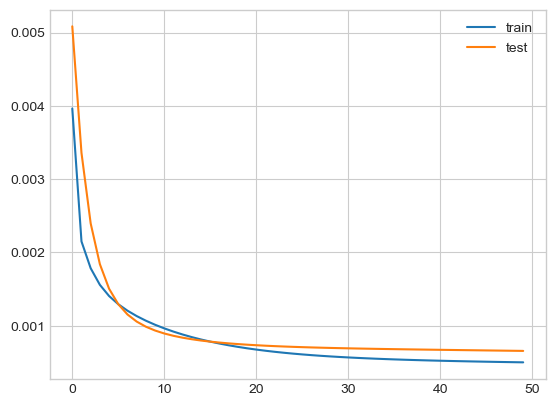

In [39]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'SGD', 'mse')

In [40]:
simpleRNN_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_sgd_mse_metrics = ["SGD", "MSE"] + simpleRNN_sgd_mse["metrics"]

297/297 [==============================] - 2s 4ms/step
Test MAE: 1.015
Test MSE: 1.637
Test RMSE: 1.280
Test R2: 0.975


##### Optimizer: SGD, Loss: MAE

Epoch 1/50
240/240 - 7s - loss: 0.0490 - val_loss: 0.0354 - 7s/epoch - 30ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0323 - val_loss: 0.0155 - 1s/epoch - 6ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0334 - val_loss: 0.0165 - 1s/epoch - 6ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0353 - val_loss: 0.0170 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0342 - val_loss: 0.0571 - 2s/epoch - 7ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0341 - val_loss: 0.0179 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0329 - val_loss: 0.0164 - 1s/epoch - 5ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0321 - val_loss: 0.0153 - 951ms/epoch - 4ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0309 - val_loss: 0.0154 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0307 - val_loss: 0.0153 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 1s - loss: 0.0297 - val_loss: 0.0148 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 1s - loss: 0.0291 - val_loss: 0.0501 - 1s/epoch - 5ms/step
Epoch 13/50
240/240 - 1s - loss: 

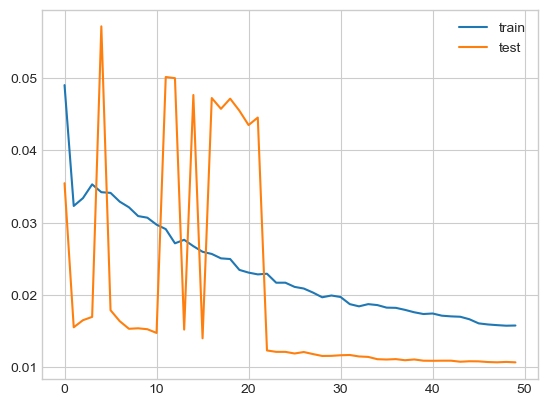

In [41]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'SGD', 'mae')

In [42]:
simpleRNN_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_sgd_mae_metrics = ["SGD", "MAE"] + simpleRNN_sgd_mae["metrics"]

297/297 [==============================] - 2s 5ms/step
Test MAE: 0.927
Test MSE: 1.527
Test RMSE: 1.236
Test R2: 0.977


##### Optimizer: SGD, Loss: MAPE

Epoch 1/50
240/240 - 9s - loss: 15617.4541 - val_loss: 16601.9062 - 9s/epoch - 37ms/step
Epoch 2/50
240/240 - 2s - loss: 16146.5830 - val_loss: 15564.8838 - 2s/epoch - 8ms/step
Epoch 3/50
240/240 - 2s - loss: 16141.3457 - val_loss: 16732.0508 - 2s/epoch - 6ms/step
Epoch 4/50
240/240 - 1s - loss: 16174.4316 - val_loss: 16360.4961 - 1s/epoch - 5ms/step
Epoch 5/50
240/240 - 1s - loss: 16161.1182 - val_loss: 18670.9688 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 1s - loss: 16172.0820 - val_loss: 16824.7070 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 2s - loss: 16174.3740 - val_loss: 16935.3066 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 16182.6377 - val_loss: 15815.2773 - 2s/epoch - 7ms/step
Epoch 9/50
240/240 - 2s - loss: 16177.1318 - val_loss: 16387.5684 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 16180.8926 - val_loss: 16362.2090 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 2s - loss: 16176.4746 - val_loss: 16284.8057 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - lo

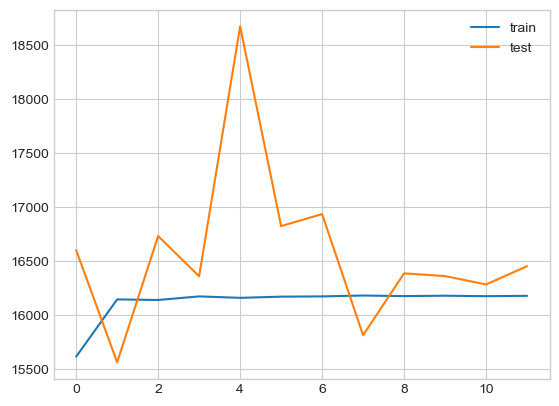

In [43]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'SGD', 'mape')

In [44]:
simpleRNN_sgd_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_sgd_mape_metrics = ["SGD", "MAPE"] + simpleRNN_sgd_mape["metrics"]

297/297 [==============================] - 3s 7ms/step
Test MAE: 2470.272
Test MSE: 6102286.479
Test RMSE: 2470.281
Test R2: -91798.927


##### Optimizer: Adamax, Loss: MSE

Epoch 1/50
240/240 - 8s - loss: 0.0095 - val_loss: 0.0066 - 8s/epoch - 31ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0034 - val_loss: 0.0044 - 2s/epoch - 8ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0023 - val_loss: 0.0029 - 2s/epoch - 7ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0015 - val_loss: 0.0020 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 2s - loss: 9.9925e-04 - val_loss: 0.0015 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 7.2678e-04 - val_loss: 0.0011 - 2s/epoch - 7ms/step
Epoch 7/50
240/240 - 2s - loss: 6.0897e-04 - val_loss: 8.4871e-04 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 5.6405e-04 - val_loss: 7.7334e-04 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 5.4820e-04 - val_loss: 7.6459e-04 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 5.3741e-04 - val_loss: 7.8512e-04 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 1s - loss: 5.1714e-04 - val_loss: 7.6894e-04 - 1s/epoch - 6ms/step
Epoch 12/50
240/240 - 2s - loss: 5.0068e-04 - val_loss: 7.5006e-04 - 

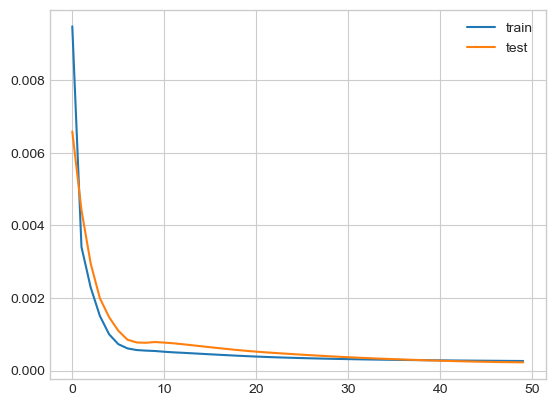

In [45]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mse')

In [46]:
simpleRNN_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adamax_mse_metrics = ["Adamax", "MSE"] + simpleRNN_adamax_mse["metrics"]

297/297 [==============================] - 2s 5ms/step
Test MAE: 0.721
Test MSE: 0.893
Test RMSE: 0.945
Test R2: 0.987


##### Optimizer: Adamax, Loss: MAE

Epoch 1/50
240/240 - 9s - loss: 0.0592 - val_loss: 0.0400 - 9s/epoch - 38ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0223 - val_loss: 0.0147 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0138 - val_loss: 0.0114 - 2s/epoch - 8ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0127 - val_loss: 0.0116 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0127 - val_loss: 0.0115 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0127 - val_loss: 0.0112 - 2s/epoch - 7ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0125 - val_loss: 0.0113 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 0.0125 - val_loss: 0.0111 - 2s/epoch - 6ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0124 - val_loss: 0.0111 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0123 - val_loss: 0.0112 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0123 - val_loss: 0.0112 - 2s/epoch - 6ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0120 - val_loss: 0.0120 - 2s/epoch - 7ms/step
Epoch 13/50
240/240 - 1s - loss: 0.0

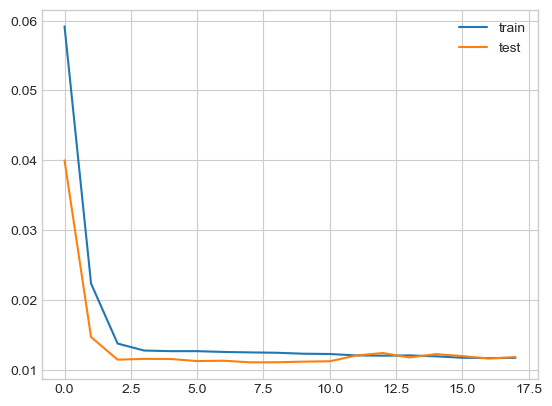

In [47]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mae')

In [48]:
simpleRNN_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adamax_mae_metrics = ["Adamax", "MAE"] + simpleRNN_adamax_mae["metrics"]

297/297 [==============================] - 2s 5ms/step
Test MAE: 0.707
Test MSE: 0.884
Test RMSE: 0.940
Test R2: 0.987


##### Optimizer: Adamax, Loss: MAPE

Epoch 1/50
240/240 - 11s - loss: 10.6006 - val_loss: 9.5016 - 11s/epoch - 48ms/step
Epoch 2/50
240/240 - 2s - loss: 6.0110 - val_loss: 4.9945 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 2s - loss: 4.0085 - val_loss: 3.4922 - 2s/epoch - 6ms/step
Epoch 4/50
240/240 - 1s - loss: 3.5290 - val_loss: 3.4005 - 1s/epoch - 6ms/step
Epoch 5/50
240/240 - 2s - loss: 3.4473 - val_loss: 3.3363 - 2s/epoch - 7ms/step
Epoch 6/50
240/240 - 2s - loss: 3.3869 - val_loss: 3.2719 - 2s/epoch - 7ms/step
Epoch 7/50
240/240 - 2s - loss: 3.3160 - val_loss: 3.2387 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 3.2447 - val_loss: 3.1852 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 3.1815 - val_loss: 3.1636 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 3.1390 - val_loss: 3.1163 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 2s - loss: 3.1044 - val_loss: 3.1278 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 3.0505 - val_loss: 3.1021 - 2s/epoch - 8ms/step
Epoch 13/50
240/240 - 2s - loss: 

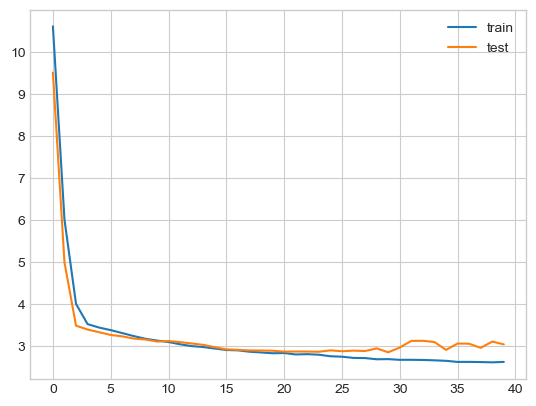

In [49]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mape')

In [50]:
simpleRNN_adamax_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adamax_mape_metrics = ["Adamax", "MAPE"] + simpleRNN_adamax_mape["metrics"]

297/297 [==============================] - 2s 4ms/step
Test MAE: 0.632
Test MSE: 0.748
Test RMSE: 0.865
Test R2: 0.989


#### LSTM 

##### Optimizer: Adam, Loss: MSE

Epoch 1/50
240/240 - 12s - loss: 0.0089 - val_loss: 0.0030 - 12s/epoch - 48ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0023 - val_loss: 0.0021 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0016 - val_loss: 0.0014 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0010 - val_loss: 0.0012 - 1s/epoch - 6ms/step
Epoch 5/50
240/240 - 1s - loss: 7.0467e-04 - val_loss: 9.5194e-04 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 1s - loss: 5.9969e-04 - val_loss: 8.6788e-04 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 1s - loss: 5.6055e-04 - val_loss: 8.0201e-04 - 1s/epoch - 5ms/step
Epoch 8/50
240/240 - 1s - loss: 5.3435e-04 - val_loss: 7.4304e-04 - 1s/epoch - 6ms/step
Epoch 9/50
240/240 - 1s - loss: 5.1237e-04 - val_loss: 6.8993e-04 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 1s - loss: 4.9313e-04 - val_loss: 6.4268e-04 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 4.7620e-04 - val_loss: 6.0129e-04 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 2s - loss: 4.6133e-04 - val_loss: 5.6

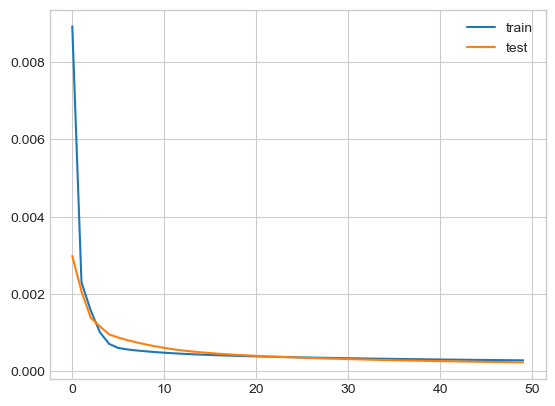

In [51]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adam', 'mse')

In [52]:
LSTM_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adam_mse_metrics = ["Adam", "MSE"] + LSTM_adam_mse["metrics"]

297/297 [==============================] - 3s 5ms/step
Test MAE: 0.811
Test MSE: 1.104
Test RMSE: 1.051
Test R2: 0.983


##### Optimizer: Adam, Loss: MAE

Epoch 1/50
240/240 - 11s - loss: 0.0623 - val_loss: 0.0345 - 11s/epoch - 46ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0293 - val_loss: 0.0218 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0179 - val_loss: 0.0206 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0175 - val_loss: 0.0217 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0169 - val_loss: 0.0197 - 2s/epoch - 7ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0164 - val_loss: 0.0182 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0160 - val_loss: 0.0164 - 1s/epoch - 6ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0155 - val_loss: 0.0161 - 1s/epoch - 6ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0152 - val_loss: 0.0156 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0150 - val_loss: 0.0150 - 1s/epoch - 6ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0147 - val_loss: 0.0143 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0145 - val_loss: 0.0138 - 2s/epoch - 7ms/step
Epoch 13/50
240/240 - 2s - loss: 0

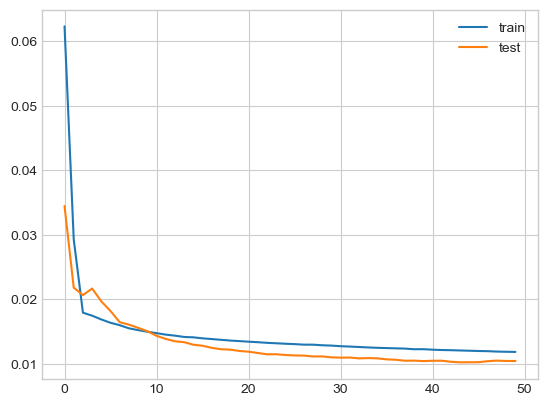

In [53]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adam', 'mae')

In [54]:
LSTM_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adam_mae_metrics = ["Adam", "MAE"] + LSTM_adam_mae["metrics"]

297/297 [==============================] - 3s 5ms/step
Test MAE: 0.653
Test MSE: 0.771
Test RMSE: 0.878
Test R2: 0.988


##### Optimizer: Adam, Loss: MAPE

Epoch 1/50
240/240 - 12s - loss: 12.8633 - val_loss: 9.5534 - 12s/epoch - 49ms/step
Epoch 2/50
240/240 - 2s - loss: 6.9736 - val_loss: 7.0493 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 1s - loss: 4.9224 - val_loss: 5.4246 - 1s/epoch - 6ms/step
Epoch 4/50
240/240 - 2s - loss: 4.0879 - val_loss: 5.0394 - 2s/epoch - 6ms/step
Epoch 5/50
240/240 - 2s - loss: 3.8611 - val_loss: 4.6909 - 2s/epoch - 6ms/step
Epoch 6/50
240/240 - 1s - loss: 3.7518 - val_loss: 4.4093 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 1s - loss: 3.6442 - val_loss: 4.2191 - 1s/epoch - 5ms/step
Epoch 8/50
240/240 - 1s - loss: 3.5680 - val_loss: 4.0446 - 1s/epoch - 5ms/step
Epoch 9/50
240/240 - 1s - loss: 3.4706 - val_loss: 3.9314 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 1s - loss: 3.4143 - val_loss: 3.8030 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 3.3705 - val_loss: 3.7128 - 1s/epoch - 6ms/step
Epoch 12/50
240/240 - 2s - loss: 3.3180 - val_loss: 3.5973 - 2s/epoch - 6ms/step
Epoch 13/50
240/240 - 2s - loss: 

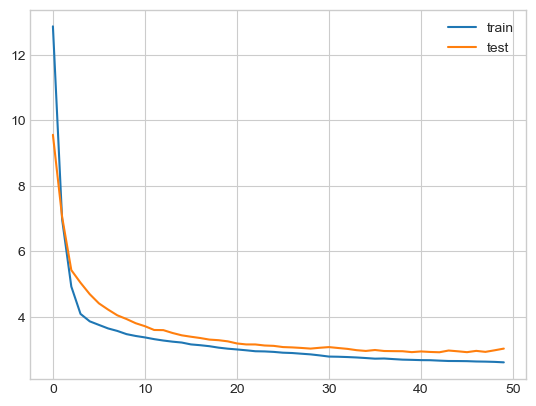

In [55]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adam', 'mape')

In [56]:
LSTM_adam_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adam_mape_metrics = ["Adam", "MAPE"] + LSTM_adam_mape["metrics"]

 55/297 [====>.........................] - ETA: 0s

297/297 [==============================] - 2s 3ms/step
Test MAE: 0.663
Test MSE: 0.791
Test RMSE: 0.889
Test R2: 0.988


##### Optimizer: SGD, Loss: MSE

Epoch 1/50
240/240 - 8s - loss: 0.0245 - val_loss: 0.0288 - 8s/epoch - 35ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0133 - val_loss: 0.0245 - 1s/epoch - 6ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0115 - val_loss: 0.0208 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0099 - val_loss: 0.0176 - 1s/epoch - 5ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0086 - val_loss: 0.0148 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0075 - val_loss: 0.0125 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0065 - val_loss: 0.0106 - 1s/epoch - 4ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0058 - val_loss: 0.0090 - 1s/epoch - 4ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0051 - val_loss: 0.0076 - 1s/epoch - 5ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0046 - val_loss: 0.0065 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0042 - val_loss: 0.0056 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0038 - val_loss: 0.0048 - 2s/epoch - 6ms/step
Epoch 13/50
240/240 - 1s - loss: 0.0

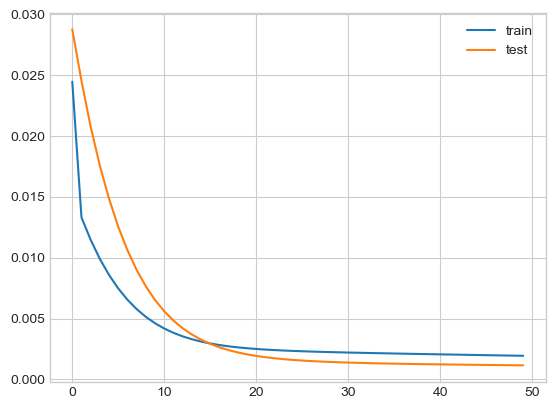

In [57]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'sgd', 'mse')

In [58]:
LSTM_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_sgd_mse_metrics = ["SGD", "MSE"] + LSTM_sgd_mse["metrics"]

297/297 [==============================] - 3s 3ms/step
Test MAE: 1.693
Test MSE: 3.971
Test RMSE: 1.993
Test R2: 0.940


##### Optimizer: SGD, Loss: MAE

Epoch 1/50
240/240 - 9s - loss: 0.0999 - val_loss: 0.1887 - 9s/epoch - 37ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0806 - val_loss: 0.1596 - 1s/epoch - 6ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0693 - val_loss: 0.1312 - 1s/epoch - 4ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0600 - val_loss: 0.1074 - 1s/epoch - 4ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0526 - val_loss: 0.0874 - 1s/epoch - 5ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0469 - val_loss: 0.0685 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0428 - val_loss: 0.0544 - 1s/epoch - 5ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0398 - val_loss: 0.0449 - 1s/epoch - 4ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0376 - val_loss: 0.0381 - 1s/epoch - 5ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0359 - val_loss: 0.0327 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 0.0344 - val_loss: 0.0294 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 1s - loss: 0.0331 - val_loss: 0.0272 - 847ms/epoch - 4ms/step
Epoch 13/50
240/240 - 1s - loss: 

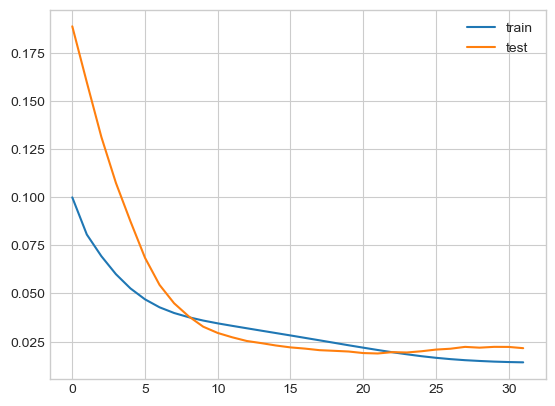

In [59]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'sgd', 'mae')

In [60]:
LSTM_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_sgd_mae_metrics = ["SGD", "MAE"] + LSTM_sgd_mae["metrics"]

297/297 [==============================] - 4s 4ms/step
Test MAE: 1.122
Test MSE: 2.028
Test RMSE: 1.424
Test R2: 0.969


##### Optimizer: SGD, Loss: MAPE

Epoch 1/50
240/240 - 16s - loss: 313.9554 - val_loss: 242.0345 - 16s/epoch - 66ms/step
Epoch 2/50
240/240 - 1s - loss: 312.2598 - val_loss: 380.6594 - 889ms/epoch - 4ms/step
Epoch 3/50
240/240 - 1s - loss: 314.5557 - val_loss: 242.2750 - 928ms/epoch - 4ms/step
Epoch 4/50
240/240 - 1s - loss: 312.2021 - val_loss: 390.7663 - 1s/epoch - 5ms/step
Epoch 5/50
240/240 - 1s - loss: 314.6759 - val_loss: 243.3764 - 1s/epoch - 4ms/step
Epoch 6/50
240/240 - 1s - loss: 314.5402 - val_loss: 407.1629 - 992ms/epoch - 4ms/step
Epoch 7/50
240/240 - 1s - loss: 312.6332 - val_loss: 520.7123 - 1s/epoch - 4ms/step
Epoch 8/50
240/240 - 1s - loss: 313.0408 - val_loss: 227.6135 - 1s/epoch - 4ms/step
Epoch 9/50
240/240 - 1s - loss: 310.1588 - val_loss: 402.3139 - 1s/epoch - 5ms/step
Epoch 10/50
240/240 - 1s - loss: 308.2021 - val_loss: 220.1280 - 1s/epoch - 4ms/step
Epoch 11/50
240/240 - 2s - loss: 311.9000 - val_loss: 242.3194 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 312.1891 - val_loss: 390.7226

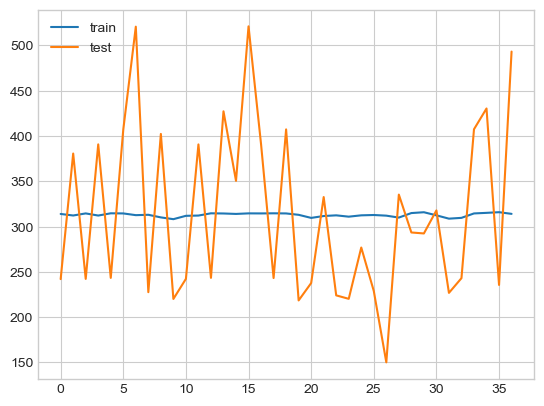

In [61]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'sgd', 'mape')

In [62]:
LSTM_sgd_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_sgd_mape_metrics = ["SGD", "MAPE"] + LSTM_sgd_mape["metrics"]

297/297 [==============================] - 5s 6ms/step
Test MAE: 29.349
Test MSE: 927.848
Test RMSE: 30.461
Test R2: -12.958


##### Optimizer: Adamax, Loss: MSE

Epoch 1/50
240/240 - 17s - loss: 0.0132 - val_loss: 0.0049 - 17s/epoch - 71ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0035 - val_loss: 0.0035 - 2s/epoch - 9ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0030 - val_loss: 0.0028 - 2s/epoch - 8ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 9ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0021 - val_loss: 0.0019 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0017 - val_loss: 0.0015 - 2s/epoch - 8ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0013 - val_loss: 0.0012 - 1s/epoch - 6ms/step
Epoch 8/50
240/240 - 2s - loss: 9.6365e-04 - val_loss: 0.0010 - 2s/epoch - 6ms/step
Epoch 9/50
240/240 - 1s - loss: 7.0214e-04 - val_loss: 8.6535e-04 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 2s - loss: 5.6760e-04 - val_loss: 8.3090e-04 - 2s/epoch - 6ms/step
Epoch 11/50
240/240 - 1s - loss: 5.1286e-04 - val_loss: 8.1244e-04 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 1s - loss: 4.9000e-04 - val_loss: 7.9174e-04 - 1s/epoch - 6ms/ste

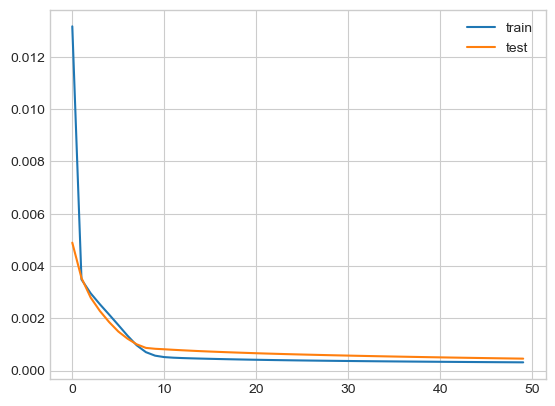

In [63]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adamax', 'mse')

In [64]:
LSTM_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adamax_mse_metrics = ["Adamax", "MSE"] + LSTM_adamax_mse["metrics"]

297/297 [==============================] - 3s 3ms/step
Test MAE: 0.866
Test MSE: 1.160
Test RMSE: 1.077
Test R2: 0.983


##### Optimizer: Adamax, Loss: MAE

Epoch 1/50
240/240 - 12s - loss: 0.0772 - val_loss: 0.0601 - 12s/epoch - 51ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0442 - val_loss: 0.0448 - 1s/epoch - 6ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0380 - val_loss: 0.0340 - 2s/epoch - 6ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0318 - val_loss: 0.0284 - 1s/epoch - 6ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0257 - val_loss: 0.0234 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0205 - val_loss: 0.0223 - 2s/epoch - 8ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0179 - val_loss: 0.0220 - 1s/epoch - 5ms/step
Epoch 8/50
240/240 - 2s - loss: 0.0173 - val_loss: 0.0229 - 2s/epoch - 6ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0171 - val_loss: 0.0226 - 1s/epoch - 4ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0169 - val_loss: 0.0222 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 0.0166 - val_loss: 0.0220 - 1s/epoch - 4ms/step
Epoch 12/50
240/240 - 1s - loss: 0.0164 - val_loss: 0.0211 - 1s/epoch - 6ms/step
Epoch 13/50
240/240 - 1s - loss: 0

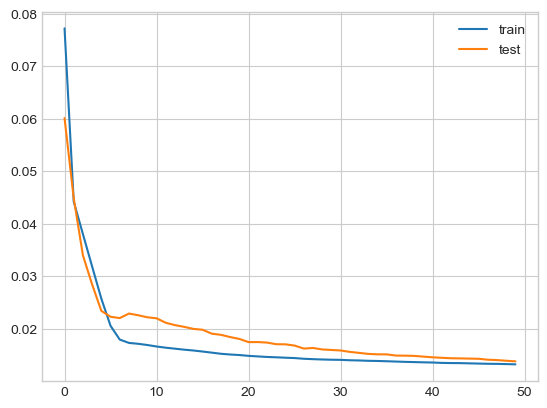

In [65]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adamax', 'mae')

In [66]:
LSTM_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adamax_mae_metrics = ["Adamax", "MAE"] + LSTM_adamax_mae["metrics"]

297/297 [==============================] - 4s 6ms/step
Test MAE: 0.801
Test MSE: 1.049
Test RMSE: 1.024
Test R2: 0.984


##### Optimizer: Adamax, Loss: MAPE

Epoch 1/50
240/240 - 16s - loss: 16.9445 - val_loss: 12.8839 - 16s/epoch - 65ms/step
Epoch 2/50
240/240 - 2s - loss: 9.1240 - val_loss: 9.9789 - 2s/epoch - 8ms/step
Epoch 3/50
240/240 - 2s - loss: 7.9959 - val_loss: 8.4335 - 2s/epoch - 9ms/step
Epoch 4/50
240/240 - 2s - loss: 6.8871 - val_loss: 7.1899 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 1s - loss: 5.6466 - val_loss: 6.4170 - 978ms/epoch - 4ms/step
Epoch 6/50
240/240 - 2s - loss: 4.4828 - val_loss: 5.8850 - 2s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 4.0505 - val_loss: 5.8879 - 1s/epoch - 4ms/step
Epoch 8/50
240/240 - 1s - loss: 3.9667 - val_loss: 5.9338 - 1s/epoch - 5ms/step
Epoch 9/50
240/240 - 1s - loss: 3.9194 - val_loss: 5.6482 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 1s - loss: 3.8247 - val_loss: 5.5113 - 1s/epoch - 6ms/step
Epoch 11/50
240/240 - 2s - loss: 3.7671 - val_loss: 5.4027 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 3.7154 - val_loss: 5.2908 - 2s/epoch - 10ms/step
Epoch 13/50
240/240 - 2s - l

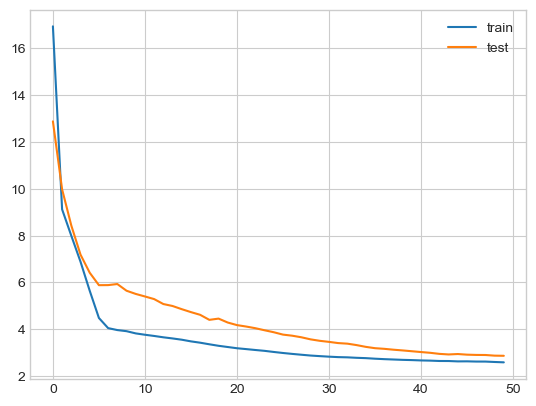

In [67]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adamax', 'mape')

In [68]:
LSTM_adamax_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adamax_mape_metrics = ["Adamax", "MAPE"] + LSTM_adamax_mape["metrics"]

297/297 [==============================] - 4s 5ms/step
Test MAE: 0.623
Test MSE: 0.716
Test RMSE: 0.846
Test R2: 0.989


#### GRU

##### Optimizer: Adam, Loss: MSE

Epoch 1/50
240/240 - 14s - loss: 0.0048 - val_loss: 0.0024 - 14s/epoch - 59ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0018 - val_loss: 0.0014 - 2s/epoch - 8ms/step
Epoch 3/50
240/240 - 2s - loss: 9.0913e-04 - val_loss: 6.9750e-04 - 2s/epoch - 6ms/step
Epoch 4/50
240/240 - 2s - loss: 5.5514e-04 - val_loss: 5.4359e-04 - 2s/epoch - 9ms/step
Epoch 5/50
240/240 - 2s - loss: 4.8366e-04 - val_loss: 5.2761e-04 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 4.6476e-04 - val_loss: 5.0522e-04 - 2s/epoch - 9ms/step
Epoch 7/50
240/240 - 2s - loss: 4.5140e-04 - val_loss: 4.8113e-04 - 2s/epoch - 8ms/step
Epoch 8/50
240/240 - 2s - loss: 4.3953e-04 - val_loss: 4.5834e-04 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 4.2863e-04 - val_loss: 4.3720e-04 - 2s/epoch - 9ms/step
Epoch 10/50
240/240 - 2s - loss: 4.1848e-04 - val_loss: 4.1765e-04 - 2s/epoch - 8ms/step
Epoch 11/50
240/240 - 2s - loss: 4.0900e-04 - val_loss: 3.9966e-04 - 2s/epoch - 8ms/step
Epoch 12/50
240/240 - 2s - loss: 4.0011e-04

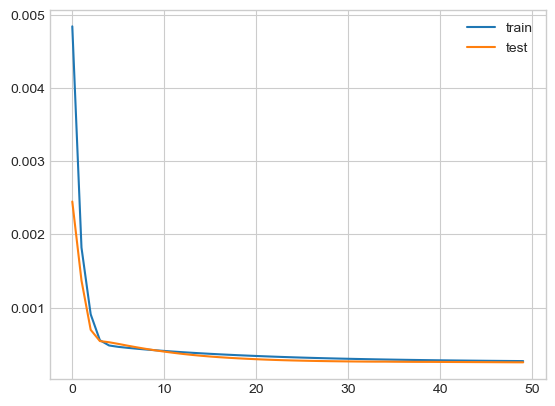

In [69]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mse')

In [70]:
GRU_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adam_mse_metrics = ["Adam", "MSE"] + GRU_adam_mse["metrics"]

297/297 [==============================] - 3s 4ms/step
Test MAE: 0.712
Test MSE: 0.850
Test RMSE: 0.922
Test R2: 0.987


##### Optimizer: Adam, Loss: MAE

Epoch 1/50
240/240 - 10s - loss: 0.0528 - val_loss: 0.0294 - 10s/epoch - 44ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0224 - val_loss: 0.0190 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0175 - val_loss: 0.0175 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0166 - val_loss: 0.0170 - 1s/epoch - 5ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0161 - val_loss: 0.0170 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0157 - val_loss: 0.0166 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0155 - val_loss: 0.0164 - 2s/epoch - 6ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0152 - val_loss: 0.0162 - 1s/epoch - 5ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0151 - val_loss: 0.0168 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0147 - val_loss: 0.0164 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 0.0147 - val_loss: 0.0173 - 1s/epoch - 6ms/step
Epoch 12/50
240/240 - 1s - loss: 0.0148 - val_loss: 0.0156 - 1s/epoch - 6ms/step
Epoch 13/50
240/240 - 1s - loss: 0

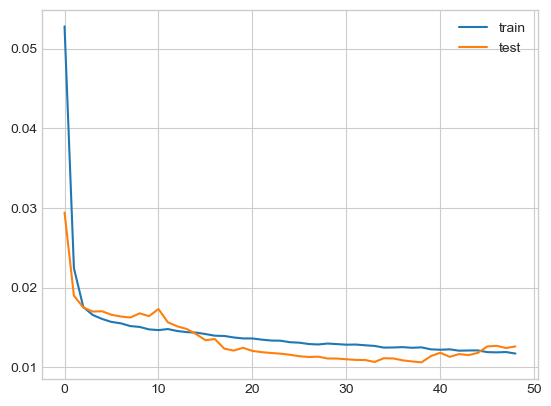

In [71]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mae')

In [72]:
GRU_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adam_mae_metrics = ["Adam", "MAE"] + GRU_adam_mae["metrics"]

297/297 [==============================] - 3s 3ms/step
Test MAE: 0.709
Test MSE: 0.892
Test RMSE: 0.944
Test R2: 0.987


##### Optimizer: Adam, Loss: MAPE

Epoch 1/50
240/240 - 11s - loss: 11.4042 - val_loss: 9.1042 - 11s/epoch - 45ms/step
Epoch 2/50
240/240 - 1s - loss: 6.5101 - val_loss: 5.1610 - 1s/epoch - 6ms/step
Epoch 3/50
240/240 - 1s - loss: 3.9724 - val_loss: 4.7049 - 973ms/epoch - 4ms/step
Epoch 4/50
240/240 - 1s - loss: 3.5975 - val_loss: 4.7003 - 1s/epoch - 4ms/step
Epoch 5/50
240/240 - 1s - loss: 3.4872 - val_loss: 5.1229 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 2s - loss: 3.3955 - val_loss: 4.6687 - 2s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 3.3211 - val_loss: 4.5989 - 1s/epoch - 4ms/step
Epoch 8/50
240/240 - 1s - loss: 3.2750 - val_loss: 4.4290 - 1s/epoch - 5ms/step
Epoch 9/50
240/240 - 2s - loss: 3.2254 - val_loss: 4.2960 - 2s/epoch - 6ms/step
Epoch 10/50
240/240 - 1s - loss: 3.1774 - val_loss: 4.0671 - 1s/epoch - 6ms/step
Epoch 11/50
240/240 - 1s - loss: 3.1434 - val_loss: 3.8562 - 1s/epoch - 6ms/step
Epoch 12/50
240/240 - 2s - loss: 3.1050 - val_loss: 3.6956 - 2s/epoch - 7ms/step
Epoch 13/50
240/240 - 2s - los

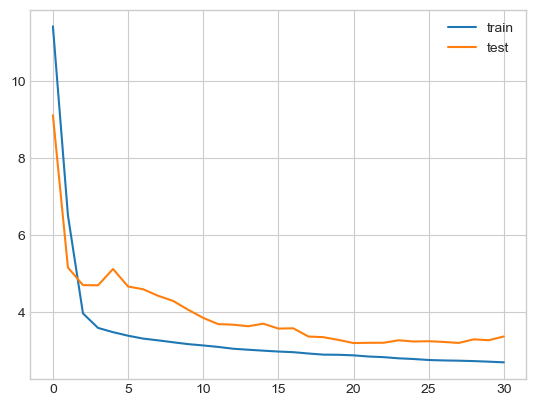

In [73]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mape')

In [74]:
GRU_adam_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adam_mape_metrics = ["Adam", "MAPE"] + GRU_adam_mape["metrics"]

297/297 [==============================] - 3s 3ms/step
Test MAE: 0.689
Test MSE: 0.837
Test RMSE: 0.915
Test R2: 0.987


##### Optimizer: SGD, Loss: MSE

Epoch 1/50
240/240 - 9s - loss: 0.0213 - val_loss: 0.0333 - 9s/epoch - 39ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0108 - val_loss: 0.0230 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0082 - val_loss: 0.0161 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0065 - val_loss: 0.0115 - 1s/epoch - 6ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0053 - val_loss: 0.0084 - 2s/epoch - 7ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0045 - val_loss: 0.0063 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0040 - val_loss: 0.0049 - 1s/epoch - 5ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0036 - val_loss: 0.0039 - 1s/epoch - 5ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0034 - val_loss: 0.0033 - 1s/epoch - 5ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0032 - val_loss: 0.0028 - 1s/epoch - 6ms/step
Epoch 11/50
240/240 - 1s - loss: 0.0030 - val_loss: 0.0025 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0029 - val_loss: 0.0022 - 2s/epoch - 7ms/step
Epoch 13/50
240/240 - 1s - loss: 0.0

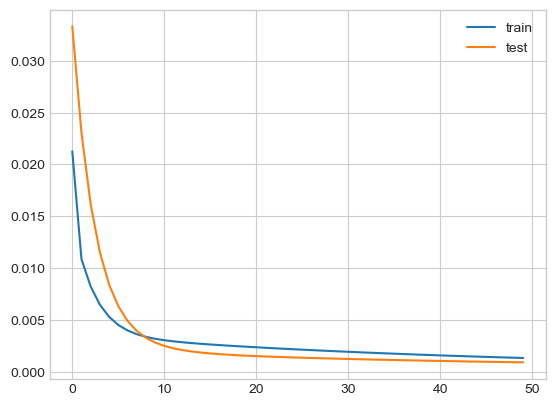

In [75]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'sgd', 'mse')

In [76]:
GRU_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_sgd_mse_metrics = ["SGD", "MSE"] + GRU_sgd_mse["metrics"]

297/297 [==============================] - 3s 4ms/step
Test MAE: 1.438
Test MSE: 2.822
Test RMSE: 1.680
Test R2: 0.958


##### Optimizer: SGD, Loss: MAE

Epoch 1/50
240/240 - 10s - loss: 0.0715 - val_loss: 0.0968 - 10s/epoch - 41ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0526 - val_loss: 0.0602 - 1s/epoch - 6ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0440 - val_loss: 0.0418 - 2s/epoch - 8ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0387 - val_loss: 0.0317 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0346 - val_loss: 0.0264 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0309 - val_loss: 0.0233 - 2s/epoch - 8ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0274 - val_loss: 0.0213 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0239 - val_loss: 0.0215 - 1s/epoch - 6ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0209 - val_loss: 0.0217 - 2s/epoch - 8ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0183 - val_loss: 0.0233 - 2s/epoch - 8ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0164 - val_loss: 0.0215 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0154 - val_loss: 0.0185 - 2s/epoch - 8ms/step
Epoch 13/50
240/240 - 1s - loss: 0

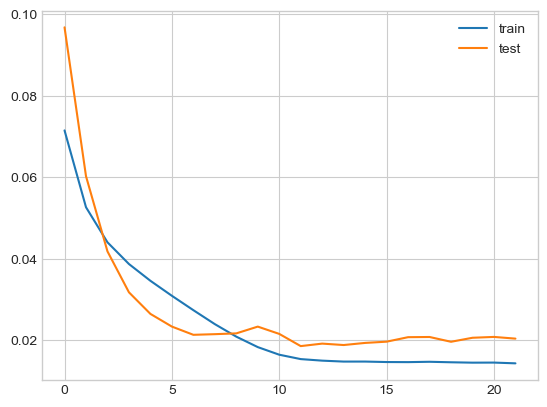

In [77]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'sgd', 'mae')

In [78]:
GRU_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_sgd_mae_metrics = ["SGD", "MAE"] + GRU_sgd_mae["metrics"]

297/297 [==============================] - 4s 7ms/step
Test MAE: 1.051
Test MSE: 1.712
Test RMSE: 1.308
Test R2: 0.974


##### Optimizer: SGD, Loss: MAPE

Epoch 1/50
240/240 - 13s - loss: 359.2170 - val_loss: 419.4524 - 13s/epoch - 54ms/step
Epoch 2/50
240/240 - 2s - loss: 316.8387 - val_loss: 426.5704 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 2s - loss: 316.5339 - val_loss: 223.3013 - 2s/epoch - 8ms/step
Epoch 4/50
240/240 - 2s - loss: 308.2573 - val_loss: 242.7531 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 2s - loss: 312.6276 - val_loss: 271.9301 - 2s/epoch - 7ms/step
Epoch 6/50
240/240 - 2s - loss: 315.6573 - val_loss: 476.4629 - 2s/epoch - 8ms/step
Epoch 7/50
240/240 - 2s - loss: 315.9453 - val_loss: 517.8667 - 2s/epoch - 8ms/step
Epoch 8/50
240/240 - 2s - loss: 311.9971 - val_loss: 192.1966 - 2s/epoch - 9ms/step
Epoch 9/50
240/240 - 2s - loss: 313.2305 - val_loss: 518.8640 - 2s/epoch - 8ms/step
Epoch 10/50
240/240 - 2s - loss: 312.4875 - val_loss: 242.5914 - 2s/epoch - 8ms/step
Epoch 11/50
240/240 - 2s - loss: 310.7513 - val_loss: 204.2675 - 2s/epoch - 8ms/step
Epoch 12/50
240/240 - 2s - loss: 310.2350 - val_loss: 429.8391 - 2s/epo

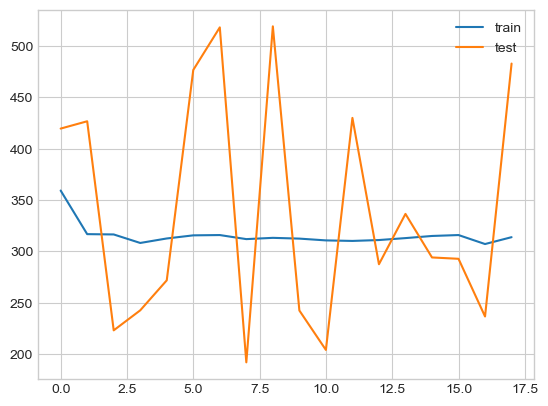

In [79]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'sgd', 'mape')

In [80]:
GRU_sgd_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_sgd_mape_metrics = ["SGD", "MAPE"] + GRU_sgd_mape["metrics"]

297/297 [==============================] - 5s 6ms/step
Test MAE: 35.865
Test MSE: 1348.784
Test RMSE: 36.726
Test R2: -19.290


##### Optimizer: Adamax, Loss: MSE

Epoch 1/50
240/240 - 15s - loss: 0.0059 - val_loss: 0.0047 - 15s/epoch - 63ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0030 - val_loss: 0.0033 - 2s/epoch - 9ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0024 - val_loss: 0.0024 - 2s/epoch - 9ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0018 - val_loss: 0.0017 - 2s/epoch - 9ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0013 - val_loss: 0.0013 - 2s/epoch - 10ms/step
Epoch 6/50
240/240 - 2s - loss: 9.3797e-04 - val_loss: 0.0010 - 2s/epoch - 9ms/step
Epoch 7/50
240/240 - 2s - loss: 7.2335e-04 - val_loss: 9.4670e-04 - 2s/epoch - 9ms/step
Epoch 8/50
240/240 - 2s - loss: 6.2593e-04 - val_loss: 9.3584e-04 - 2s/epoch - 9ms/step
Epoch 9/50
240/240 - 2s - loss: 5.8225e-04 - val_loss: 9.4343e-04 - 2s/epoch - 8ms/step
Epoch 10/50
240/240 - 2s - loss: 5.6045e-04 - val_loss: 9.4171e-04 - 2s/epoch - 8ms/step
Epoch 11/50
240/240 - 2s - loss: 5.4606e-04 - val_loss: 9.2742e-04 - 2s/epoch - 8ms/step
Epoch 12/50
240/240 - 2s - loss: 5.3324e-04 - val_loss: 9.0675e-04 - 2

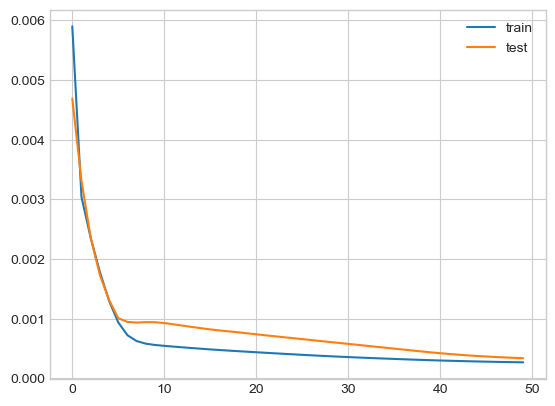

In [81]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mse')

In [82]:
GRU_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adamax_mse_metrics = ["Adamax", "MSE"] + GRU_adamax_mse["metrics"]

297/297 [==============================] - 4s 6ms/step
Test MAE: 0.777
Test MSE: 0.965
Test RMSE: 0.983
Test R2: 0.985


##### Optimizer: Adamax, Loss: MAE

Epoch 1/50
240/240 - 16s - loss: 0.0487 - val_loss: 0.0394 - 16s/epoch - 66ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0344 - val_loss: 0.0292 - 2s/epoch - 9ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0237 - val_loss: 0.0208 - 2s/epoch - 7ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0182 - val_loss: 0.0201 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0169 - val_loss: 0.0195 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0165 - val_loss: 0.0183 - 2s/epoch - 7ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0162 - val_loss: 0.0180 - 2s/epoch - 9ms/step
Epoch 8/50
240/240 - 2s - loss: 0.0160 - val_loss: 0.0176 - 2s/epoch - 10ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0157 - val_loss: 0.0175 - 2s/epoch - 9ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0154 - val_loss: 0.0174 - 2s/epoch - 9ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0152 - val_loss: 0.0173 - 2s/epoch - 9ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0150 - val_loss: 0.0168 - 2s/epoch - 9ms/step
Epoch 13/50
240/240 - 2s - loss: 

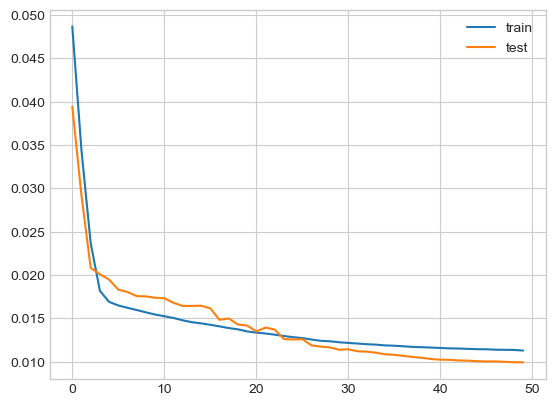

In [83]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mae')

In [84]:
GRU_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adamax_mae_metrics = ["Adamax", "MAE"] + GRU_adamax_mae["metrics"]

297/297 [==============================] - 2s 4ms/step
Test MAE: 0.648
Test MSE: 0.764
Test RMSE: 0.874
Test R2: 0.989


##### Optimizer: Adamax, Loss: MAPE

Epoch 1/50
240/240 - 11s - loss: 13.4158 - val_loss: 13.6942 - 11s/epoch - 45ms/step
Epoch 2/50
240/240 - 2s - loss: 8.6606 - val_loss: 9.2856 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 1s - loss: 7.1113 - val_loss: 7.2291 - 1s/epoch - 6ms/step
Epoch 4/50
240/240 - 1s - loss: 5.7045 - val_loss: 6.2731 - 1s/epoch - 5ms/step
Epoch 5/50
240/240 - 1s - loss: 4.5681 - val_loss: 5.4393 - 1s/epoch - 5ms/step
Epoch 6/50
240/240 - 1s - loss: 3.7863 - val_loss: 4.7761 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 2s - loss: 3.4878 - val_loss: 4.7470 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 3.3831 - val_loss: 4.6131 - 2s/epoch - 7ms/step
Epoch 9/50
240/240 - 1s - loss: 3.3060 - val_loss: 4.3943 - 1s/epoch - 4ms/step
Epoch 10/50
240/240 - 2s - loss: 3.2305 - val_loss: 4.2662 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 2s - loss: 3.1615 - val_loss: 4.0708 - 2s/epoch - 6ms/step
Epoch 12/50
240/240 - 2s - loss: 3.1068 - val_loss: 3.9005 - 2s/epoch - 6ms/step
Epoch 13/50
240/240 - 1s - loss:

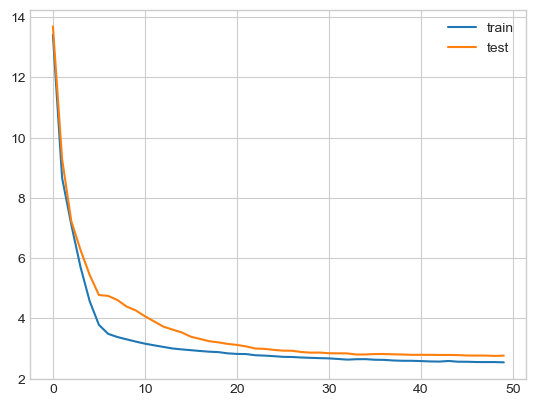

In [85]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mape')

In [86]:
GRU_adamax_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adamax_mape_metrics = ["Adamax", "MAPE"] + GRU_adamax_mape["metrics"]

297/297 [==============================] - 3s 6ms/step
Test MAE: 0.609
Test MSE: 0.695
Test RMSE: 0.834
Test R2: 0.990


#### Results

In [87]:
columns = ["OPTIMIZER", "LOSS", "MAE", "MSE", "RMSE", "R2"]
indexes = []
values = []

simpleRNN_res = [simpleRNN_adam_mse_metrics, simpleRNN_adam_mae_metrics, simpleRNN_adam_mape_metrics, 
                 simpleRNN_sgd_mse_metrics, simpleRNN_sgd_mae_metrics, simpleRNN_sgd_mape_metrics, 
                 simpleRNN_adamax_mse_metrics, simpleRNN_adamax_mae_metrics, simpleRNN_adamax_mape_metrics]
LSTM_res = [LSTM_adam_mse_metrics, LSTM_adam_mae_metrics, LSTM_adam_mape_metrics, 
            LSTM_sgd_mse_metrics, LSTM_sgd_mae_metrics, LSTM_sgd_mape_metrics,
            LSTM_adamax_mse_metrics, LSTM_adamax_mae_metrics, LSTM_adamax_mape_metrics]
GRU_res = [GRU_adam_mse_metrics, GRU_adam_mae_metrics, GRU_adam_mape_metrics,
           GRU_sgd_mse_metrics, GRU_sgd_mae_metrics, GRU_sgd_mape_metrics, 
           GRU_adamax_mse_metrics, GRU_adamax_mae_metrics, GRU_adamax_mape_metrics]

for r in simpleRNN_res:
    indexes.append("Simple RNN")
    values.append(r)
for r in LSTM_res:
    indexes.append("LSTM")
    values.append(r)
for r in GRU_res:
    indexes.append("GRU")
    values.append(r)

univariate_res = pd.DataFrame(values, columns=columns)
univariate_res.index = indexes

In [88]:
univariate_res

OPTIMIZER  LOSS          MAE           MSE         RMSE  \
Simple RNN      Adam   MSE     0.907467  1.440541e+00     1.200225   
Simple RNN      Adam   MAE     0.606131  6.926958e-01     0.832283   
Simple RNN      Adam  MAPE     0.652322  7.815555e-01     0.884056   
Simple RNN       SGD   MSE     1.014763  1.637401e+00     1.279610   
Simple RNN       SGD   MAE     0.926961  1.527378e+00     1.235871   
Simple RNN       SGD  MAPE  2470.272111  6.102286e+06  2470.280648   
Simple RNN    Adamax   MSE     0.720983  8.933001e-01     0.945146   
Simple RNN    Adamax   MAE     0.707226  8.838889e-01     0.940154   
Simple RNN    Adamax  MAPE     0.631773  7.484329e-01     0.865120   
LSTM            Adam   MSE     0.810770  1.103846e+00     1.050641   
LSTM            Adam   MAE     0.652745  7.706935e-01     0.877891   
LSTM            Adam  MAPE     0.663067  7.906149e-01     0.889165   
LSTM             SGD   MSE     1.692876  3.971385e+00     1.992833   
LSTM             SGD   MAE     1.122251  2.027991e+00     1.424076   
LSTM             SGD  MAPE    29.349037  9.278483e+02    30.460602   
LSTM          Adamax   MSE     0.865813  1.160368e+00     1.077204   
LSTM          Adamax   MAE     0.800647  1.048772e+00     1.024096   
LSTM          Adamax  MAPE     0.622538  7.161498e-01     0.846256   
GRU             Adam   MSE     0.712114  8.496102e-01     0.921743   
GRU             Adam   MAE     0.709118  8.919891e-01     0.944452   
GRU             Adam  MAPE     0.688566  8.370524e-01     0.914906   
GRU              SGD   MSE     1.438439  2.822488e+00     1.680026   
GRU              SGD   MAE     1.051098  1.711712e+00     1.308324   
GRU              SGD  MAPE    35.864688  1.348784e+03    36.725794   
GRU           Adamax   MSE     0.776518  9.654425e-01     0.982569   
GRU           Adamax   MAE     0.647709  7.644124e-01     0.874307   
GRU           Adamax  MAPE     0.608942  6.951888e-01     0.833780   

                      R2  
Simple RNN      0.978329  
Simple RNN      0.989579  
Simple RNN      0.988243  
Simple RNN      0.975368  
Simple RNN      0.977023  
Simple RNN -91798.927296  
Simple RNN      0.986562  
Simple RNN      0.986703  
Simple RNN      0.988741  
LSTM            0.983394  
LSTM            0.988406  
LSTM            0.988106  
LSTM            0.940256  
LSTM            0.969492  
LSTM          -12.958113  
LSTM            0.982544  
LSTM            0.984223  
LSTM            0.989227  
GRU             0.987219  
GRU             0.986581  
GRU             0.987408  
GRU             0.957540  
GRU             0.974250  
GRU           -19.290472  
GRU             0.985476  
GRU             0.988501  
GRU             0.989542

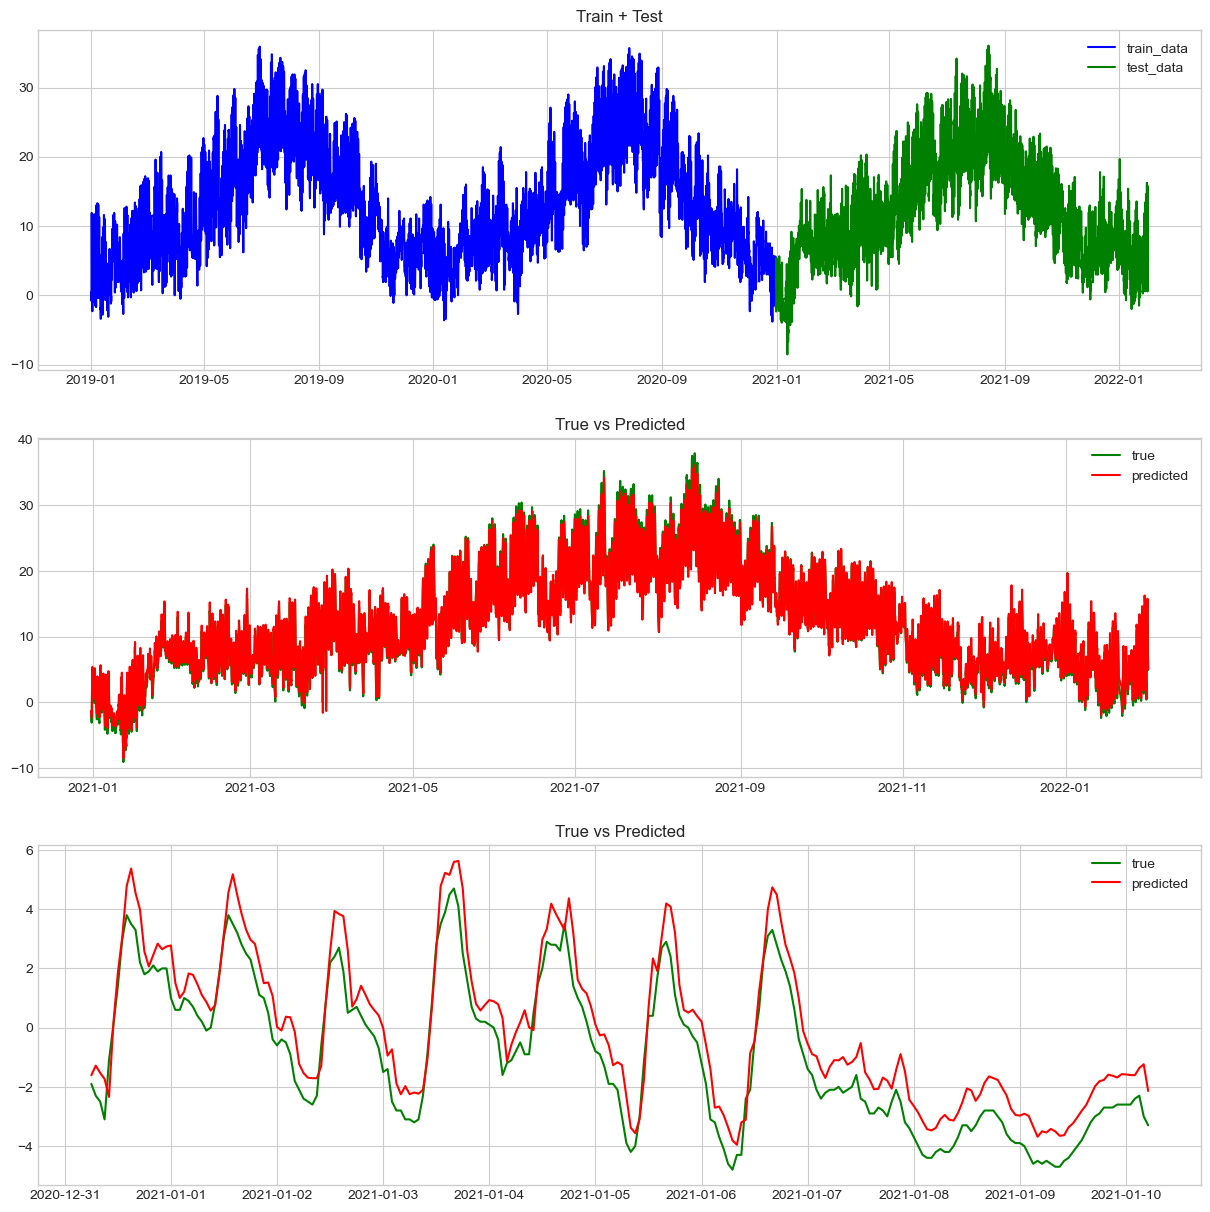

In [89]:
visualize_predictions(reframed.index, prepared_data["n_train_hours"], prepared_data["inv_train_y"], GRU_adam_mse["inv_y"], GRU_adam_mse["inv_pred_y"])

### Multivariate forecasting

In [169]:
reframed = series_to_supervised(data, data.index, 5, 1)

In [170]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27019 entries, 2019-01-01 05:59:59 to 2022-01-31 23:59:59
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-5)  27019 non-null  float64
 1   var2(t-5)  27019 non-null  float64
 2   var3(t-5)  27019 non-null  float64
 3   var4(t-5)  27019 non-null  float64
 4   var5(t-5)  27019 non-null  float64
 5   var1(t-4)  27019 non-null  float64
 6   var2(t-4)  27019 non-null  float64
 7   var3(t-4)  27019 non-null  float64
 8   var4(t-4)  27019 non-null  float64
 9   var5(t-4)  27019 non-null  float64
 10  var1(t-3)  27019 non-null  float64
 11  var2(t-3)  27019 non-null  float64
 12  var3(t-3)  27019 non-null  float64
 13  var4(t-3)  27019 non-null  float64
 14  var5(t-3)  27019 non-null  float64
 15  var1(t-2)  27019 non-null  float64
 16  var2(t-2)  27019 non-null  float64
 17  var3(t-2)  27019 non-null  float64
 18  var4(t-2)  27019 non-null  float64
 19  var5(t-2)  

In [171]:
reframed.drop(reframed.columns[[26, 27, 28, 29]], axis=1, inplace=True)

In [172]:
reframed.head()

var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  \
time                                                                         
2019-01-01 05:59:59        3.1       50.0      949.0        0.0   0.284941   
2019-01-01 06:59:59        2.9       49.0      949.0        0.0   0.805646   
2019-01-01 07:59:59        3.1       46.0      949.0        0.0   0.408440   
2019-01-01 08:59:59        1.9       51.0      949.0        0.0   0.188938   
2019-01-01 09:59:59        0.7       56.0      949.0        0.0   0.343035   

                     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  \
time                                                                         
2019-01-01 05:59:59        2.9       49.0      949.0        0.0   0.805646   
2019-01-01 06:59:59        3.1       46.0      949.0        0.0   0.408440   
2019-01-01 07:59:59        1.9       51.0      949.0        0.0   0.188938   
2019-01-01 08:59:59        0.7       56.0      949.0        0.0   0.343035   
2019-01-01 09:59:59        0.5       53.0      949.0        0.0   0.520721   

                     ...  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  \
time                 ...                                               
2019-01-01 05:59:59  ...       51.0      949.0        0.0   0.188938   
2019-01-01 06:59:59  ...       56.0      949.0        0.0   0.343035   
2019-01-01 07:59:59  ...       53.0      949.0        0.0   0.520721   
2019-01-01 08:59:59  ...       55.0      949.0        0.0   0.772741   
2019-01-01 09:59:59  ...       60.0      949.0        0.0   0.176725   

                     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
time                                                                         
2019-01-01 05:59:59        0.7       56.0      949.0        0.0   0.343035   
2019-01-01 06:59:59        0.5       53.0      949.0        0.0   0.520721   
2019-01-01 07:59:59        0.0       55.0      949.0        0.0   0.772741   
2019-01-01 08:59:59       -0.8       60.0      949.0        0.0   0.176725   
2019-01-01 09:59:59        0.0       56.0      949.0       10.0   0.746134   

                     var1(t)  
time                          
2019-01-01 05:59:59      0.5  
2019-01-01 06:59:59      0.0  
2019-01-01 07:59:59     -0.8  
2019-01-01 08:59:59      0.0  
2019-01-01 09:59:59      2.2  

[5 rows x 26 columns]

In [173]:
prepared_data = prepare_dataset(reframed)

(15360, 1, 25) (15360,) (9499, 1, 25) (9499,) (2160, 1, 25) (2160,)


#### SimpleRNN

##### Optimizer: Adam, Loss: MSE

Epoch 1/50
240/240 - 8s - loss: 0.0430 - val_loss: 0.0061 - 8s/epoch - 32ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0031 - val_loss: 0.0030 - 1s/epoch - 6ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0019 - val_loss: 0.0022 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0015 - val_loss: 0.0018 - 1s/epoch - 6ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0012 - val_loss: 0.0012 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 2s - loss: 9.4943e-04 - val_loss: 8.0554e-04 - 2s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 7.8263e-04 - val_loss: 6.2246e-04 - 1s/epoch - 6ms/step
Epoch 8/50
240/240 - 1s - loss: 6.9943e-04 - val_loss: 5.6984e-04 - 1s/epoch - 6ms/step
Epoch 9/50
240/240 - 1s - loss: 6.8263e-04 - val_loss: 5.7294e-04 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 2s - loss: 6.6316e-04 - val_loss: 6.0410e-04 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 2s - loss: 6.3882e-04 - val_loss: 5.3396e-04 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 6.1166e-04 - val_loss: 3.9923e-04 - 

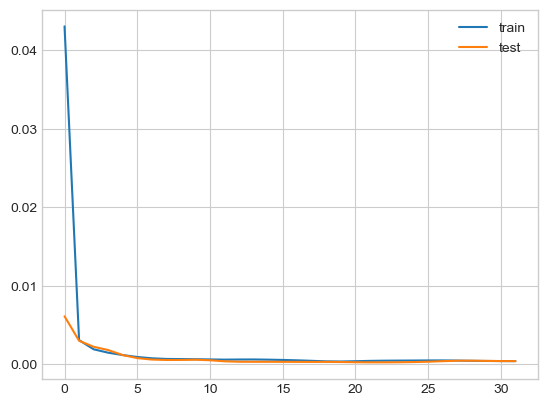

In [95]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mse')

In [96]:
simpleRNN_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adam_mse_metrics = ["Adam", "MSE"] + simpleRNN_adam_mse["metrics"]

297/297 [==============================] - 2s 5ms/step
Test MAE: 0.719
Test MSE: 0.867
Test RMSE: 0.931
Test R2: 0.987


##### Optimizer: Adam, Loss: MAE

Epoch 1/50
240/240 - 7s - loss: 0.0548 - val_loss: 0.0382 - 7s/epoch - 29ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0393 - val_loss: 0.0334 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0302 - val_loss: 0.0337 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0258 - val_loss: 0.0299 - 1s/epoch - 6ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0294 - val_loss: 0.0286 - 1s/epoch - 5ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0263 - val_loss: 0.0254 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0287 - val_loss: 0.0235 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0225 - val_loss: 0.0228 - 1s/epoch - 6ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0280 - val_loss: 0.0180 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0239 - val_loss: 0.0188 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 1s - loss: 0.0240 - val_loss: 0.0231 - 1s/epoch - 6ms/step
Epoch 12/50
240/240 - 1s - loss: 0.0189 - val_loss: 0.0141 - 1s/epoch - 6ms/step
Epoch 13/50
240/240 - 1s - loss: 0.0

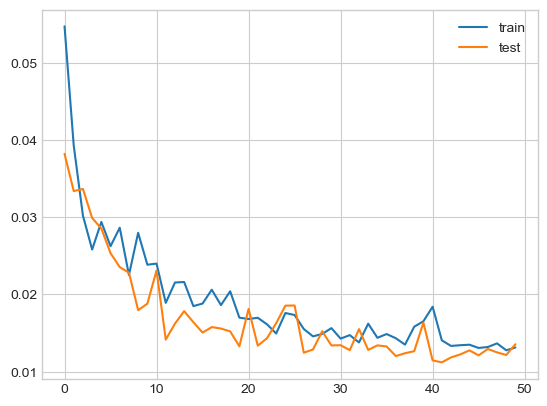

In [97]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mae')

In [98]:
simpleRNN_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adam_mae_metrics = ["Adam", "MAE"] + simpleRNN_adam_mae["metrics"]

297/297 [==============================] - 2s 5ms/step
Test MAE: 0.669
Test MSE: 0.742
Test RMSE: 0.861
Test R2: 0.989


##### Optimizer: Adam, Loss: MAPE

Epoch 1/50
240/240 - 6s - loss: 18.4264 - val_loss: 11.5824 - 6s/epoch - 24ms/step
Epoch 2/50
240/240 - 1s - loss: 11.2524 - val_loss: 6.8088 - 1s/epoch - 5ms/step
Epoch 3/50
240/240 - 1s - loss: 8.3805 - val_loss: 10.2546 - 992ms/epoch - 4ms/step
Epoch 4/50
240/240 - 1s - loss: 7.5538 - val_loss: 8.3315 - 1s/epoch - 4ms/step
Epoch 5/50
240/240 - 1s - loss: 5.0298 - val_loss: 5.7891 - 1s/epoch - 4ms/step
Epoch 6/50
240/240 - 1s - loss: 5.5385 - val_loss: 5.1480 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 5.1595 - val_loss: 6.1029 - 1s/epoch - 6ms/step
Epoch 8/50
240/240 - 1s - loss: 4.9531 - val_loss: 4.4832 - 1s/epoch - 5ms/step
Epoch 9/50
240/240 - 2s - loss: 4.2712 - val_loss: 4.9579 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 1s - loss: 4.3052 - val_loss: 5.3499 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 4.5620 - val_loss: 5.6100 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 1s - loss: 4.1439 - val_loss: 4.1400 - 1s/epoch - 5ms/step
Epoch 13/50
240/240 - 1s - lo

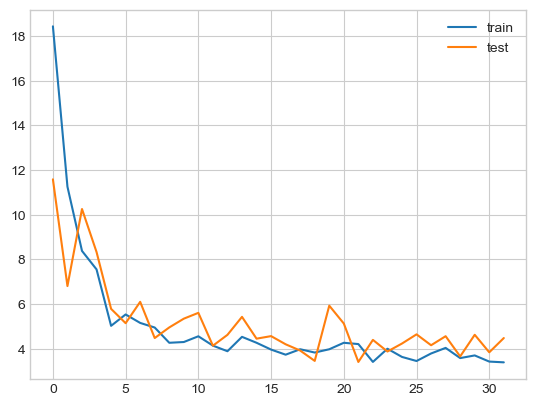

In [99]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mape')

In [100]:
simpleRNN_adam_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adam_mape_metrics = ["Adam", "MAPE"] + simpleRNN_adam_mape["metrics"]

297/297 [==============================] - 2s 6ms/step
Test MAE: 0.608
Test MSE: 0.663
Test RMSE: 0.814
Test R2: 0.990


##### Optimizer: SGD, Loss: MSE

Epoch 1/50
240/240 - 5s - loss: 0.0218 - val_loss: 0.0113 - 5s/epoch - 21ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0062 - val_loss: 0.0074 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0045 - val_loss: 0.0055 - 1s/epoch - 4ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0036 - val_loss: 0.0044 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0030 - val_loss: 0.0036 - 1s/epoch - 5ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0026 - val_loss: 0.0031 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0023 - val_loss: 0.0026 - 908ms/epoch - 4ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0020 - val_loss: 0.0023 - 1s/epoch - 5ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0018 - val_loss: 0.0021 - 1s/epoch - 5ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0017 - val_loss: 0.0018 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 0.0015 - val_loss: 0.0017 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 1s - loss: 0.0014 - val_loss: 0.0015 - 888ms/epoch - 4ms/step
Epoch 13/50
240/240 - 1s - los

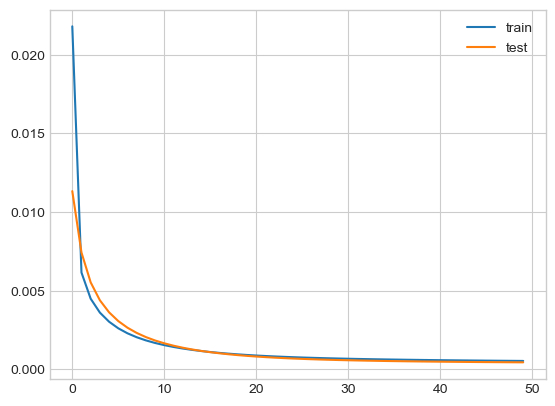

In [101]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'SGD', 'mse')

In [102]:
simpleRNN_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_sgd_mse_metrics = ["SGD", "MSE"] + simpleRNN_sgd_mse["metrics"]

297/297 [==============================] - 2s 5ms/step
Test MAE: 0.878
Test MSE: 1.294
Test RMSE: 1.138
Test R2: 0.981


##### Optimizer: SGD, Loss: MAE

Epoch 1/50
240/240 - 6s - loss: 0.0878 - val_loss: 0.1147 - 6s/epoch - 24ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0662 - val_loss: 0.1233 - 1s/epoch - 5ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0646 - val_loss: 0.1108 - 2s/epoch - 8ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0603 - val_loss: 0.1110 - 1s/epoch - 6ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0575 - val_loss: 0.0333 - 2s/epoch - 7ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0548 - val_loss: 0.0260 - 2s/epoch - 7ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0516 - val_loss: 0.0856 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0464 - val_loss: 0.0680 - 1s/epoch - 6ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0449 - val_loss: 0.0245 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0416 - val_loss: 0.0608 - 1s/epoch - 6ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0391 - val_loss: 0.0683 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0386 - val_loss: 0.0588 - 2s/epoch - 7ms/step
Epoch 13/50
240/240 - 2s - loss: 0.0

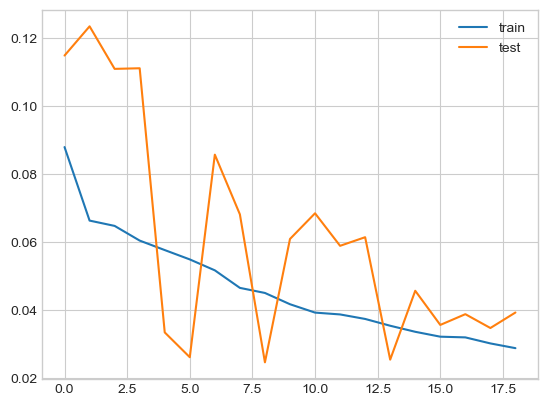

In [103]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'SGD', 'mae')

In [104]:
simpleRNN_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_sgd_mae_metrics = ["SGD", "MAE"] + simpleRNN_sgd_mae["metrics"]

297/297 [==============================] - 2s 6ms/step
Test MAE: 1.819
Test MSE: 5.171
Test RMSE: 2.274
Test R2: 0.922


##### Optimizer: SGD, Loss: MAPE

Epoch 1/50
240/240 - 8s - loss: 15895.9229 - val_loss: 15681.1689 - 8s/epoch - 32ms/step
Epoch 2/50
240/240 - 1s - loss: 16174.9092 - val_loss: 17544.4434 - 1s/epoch - 6ms/step
Epoch 3/50
240/240 - 1s - loss: 16174.3604 - val_loss: 15328.4639 - 1s/epoch - 6ms/step
Epoch 4/50
240/240 - 1s - loss: 16110.7988 - val_loss: 17514.9102 - 1s/epoch - 6ms/step
Epoch 5/50
240/240 - 1s - loss: 16060.8379 - val_loss: 15787.7090 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 1s - loss: 16016.8945 - val_loss: 15561.5664 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 15979.8311 - val_loss: 16241.8125 - 1s/epoch - 5ms/step
Epoch 8/50
240/240 - 1s - loss: 15927.5039 - val_loss: 15972.6797 - 1s/epoch - 5ms/step
Epoch 9/50
240/240 - 2s - loss: 15925.6592 - val_loss: 13794.4707 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 1s - loss: 15624.5215 - val_loss: 14265.2910 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 15964.9893 - val_loss: 15412.3477 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 2s - lo

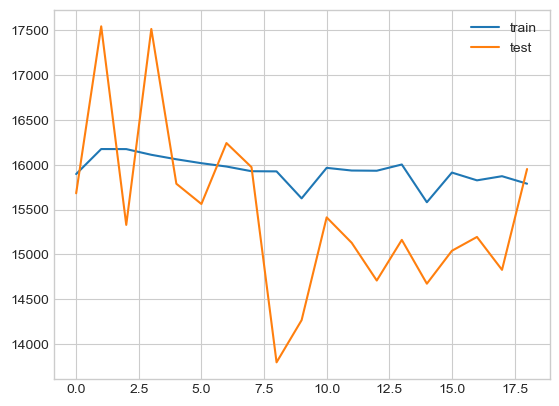

In [105]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'SGD', 'mape')

In [106]:
simpleRNN_sgd_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_sgd_mape_metrics = ["SGD", "MAPE"] + simpleRNN_sgd_mape["metrics"]

297/297 [==============================] - 3s 6ms/step
Test MAE: 2276.276
Test MSE: 5210726.982
Test RMSE: 2282.702
Test R2: -78386.726


##### Optimizer: Adamax, Loss: MSE

Epoch 1/50
240/240 - 7s - loss: 0.0262 - val_loss: 0.0104 - 7s/epoch - 30ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0054 - val_loss: 0.0073 - 1s/epoch - 5ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0033 - val_loss: 0.0050 - 2s/epoch - 7ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0022 - val_loss: 0.0036 - 1s/epoch - 6ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0016 - val_loss: 0.0024 - 2s/epoch - 7ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0012 - val_loss: 0.0017 - 2s/epoch - 8ms/step
Epoch 7/50
240/240 - 2s - loss: 9.7724e-04 - val_loss: 0.0013 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 8.3374e-04 - val_loss: 0.0014 - 2s/epoch - 7ms/step
Epoch 9/50
240/240 - 2s - loss: 7.3646e-04 - val_loss: 0.0011 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 6.4581e-04 - val_loss: 9.3479e-04 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 2s - loss: 5.5941e-04 - val_loss: 7.7364e-04 - 2s/epoch - 8ms/step
Epoch 12/50
240/240 - 1s - loss: 5.0647e-04 - val_loss: 6.4755e-04 - 1s/epoch - 6ms/step


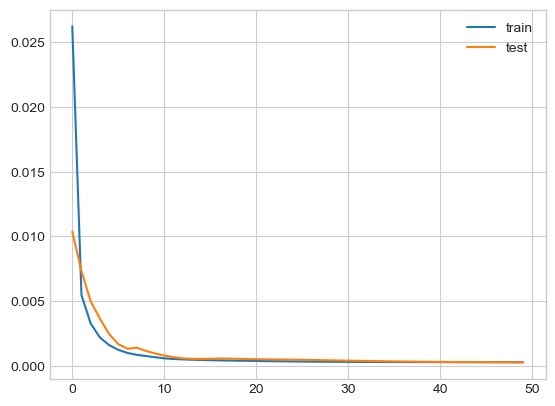

In [107]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mse')

In [108]:
simpleRNN_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adamax_mse_metrics = ["Adamax", "MSE"] + simpleRNN_adamax_mse["metrics"]

297/297 [==============================] - 3s 6ms/step
Test MAE: 0.603
Test MSE: 0.650
Test RMSE: 0.806
Test R2: 0.990


##### Optimizer: Adamax, Loss: MAE

Epoch 1/50
240/240 - 7s - loss: 0.0747 - val_loss: 0.0725 - 7s/epoch - 31ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0458 - val_loss: 0.0539 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0376 - val_loss: 0.0381 - 1s/epoch - 6ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0314 - val_loss: 0.0247 - 1s/epoch - 5ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0270 - val_loss: 0.0214 - 1s/epoch - 5ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0237 - val_loss: 0.0187 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0219 - val_loss: 0.0199 - 1s/epoch - 6ms/step
Epoch 8/50
240/240 - 2s - loss: 0.0210 - val_loss: 0.0200 - 2s/epoch - 7ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0204 - val_loss: 0.0192 - 2s/epoch - 6ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0197 - val_loss: 0.0185 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0190 - val_loss: 0.0227 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 1s - loss: 0.0192 - val_loss: 0.0205 - 1s/epoch - 5ms/step
Epoch 13/50
240/240 - 2s - loss: 0.0

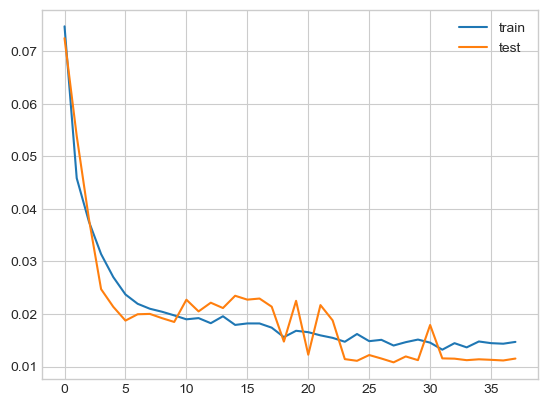

In [109]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mae')

In [110]:
simpleRNN_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adamax_mae_metrics = ["Adamax", "MAE"] + simpleRNN_adamax_mae["metrics"]

297/297 [==============================] - 2s 5ms/step
Test MAE: 0.618
Test MSE: 0.699
Test RMSE: 0.836
Test R2: 0.989


##### Optimizer: Adamax, Loss: MAPE

Epoch 1/50
240/240 - 10s - loss: 33.8120 - val_loss: 38.6417 - 10s/epoch - 43ms/step
Epoch 2/50
240/240 - 2s - loss: 19.4909 - val_loss: 24.7822 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 2s - loss: 11.5820 - val_loss: 16.0419 - 2s/epoch - 7ms/step
Epoch 4/50
240/240 - 2s - loss: 8.8703 - val_loss: 13.5036 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 2s - loss: 7.4792 - val_loss: 11.8387 - 2s/epoch - 7ms/step
Epoch 6/50
240/240 - 2s - loss: 6.4801 - val_loss: 9.7978 - 2s/epoch - 7ms/step
Epoch 7/50
240/240 - 2s - loss: 5.7885 - val_loss: 7.7135 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 5.3989 - val_loss: 6.2738 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 5.2018 - val_loss: 5.6291 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 4.9814 - val_loss: 5.4451 - 2s/epoch - 8ms/step
Epoch 11/50
240/240 - 2s - loss: 4.7389 - val_loss: 5.2461 - 2s/epoch - 8ms/step
Epoch 12/50
240/240 - 2s - loss: 4.5916 - val_loss: 5.0662 - 2s/epoch - 7ms/step
Epoch 13/50
240/240 - 2s -

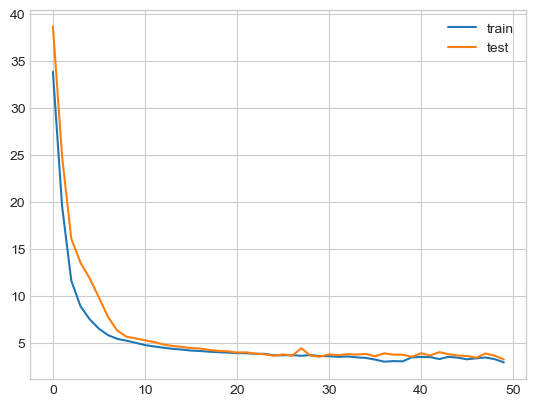

In [111]:
model = train_SimpleRNN_model(prepared_data["train_X"], prepared_data["train_y"], 
                              prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mape')

In [112]:
simpleRNN_adamax_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
simpleRNN_adamax_mape_metrics = ["Adamax", "MAPE"] + simpleRNN_adamax_mape["metrics"]

297/297 [==============================] - 3s 6ms/step
Test MAE: 0.625
Test MSE: 0.677
Test RMSE: 0.823
Test R2: 0.990


#### LSTM

##### Optimizer: Adam, Loss: MSE

Epoch 1/50
240/240 - 15s - loss: 0.0049 - val_loss: 0.0080 - 15s/epoch - 64ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0021 - val_loss: 0.0034 - 2s/epoch - 10ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0012 - val_loss: 0.0018 - 2s/epoch - 8ms/step
Epoch 4/50
240/240 - 2s - loss: 8.6071e-04 - val_loss: 0.0013 - 2s/epoch - 9ms/step
Epoch 5/50
240/240 - 2s - loss: 6.7167e-04 - val_loss: 0.0010 - 2s/epoch - 9ms/step
Epoch 6/50
240/240 - 2s - loss: 5.7810e-04 - val_loss: 8.0625e-04 - 2s/epoch - 7ms/step
Epoch 7/50
240/240 - 2s - loss: 5.1661e-04 - val_loss: 6.1882e-04 - 2s/epoch - 9ms/step
Epoch 8/50
240/240 - 2s - loss: 4.7297e-04 - val_loss: 5.2759e-04 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 4.4652e-04 - val_loss: 4.7766e-04 - 2s/epoch - 8ms/step
Epoch 10/50
240/240 - 2s - loss: 4.2415e-04 - val_loss: 4.1775e-04 - 2s/epoch - 8ms/step
Epoch 11/50
240/240 - 2s - loss: 4.0373e-04 - val_loss: 3.7224e-04 - 2s/epoch - 9ms/step
Epoch 12/50
240/240 - 2s - loss: 3.8977e-04 - val_loss: 3.

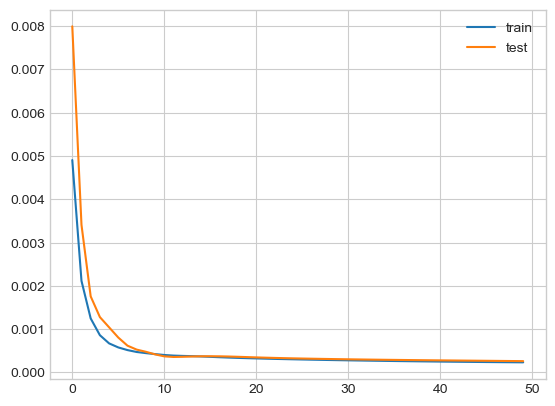

In [113]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mse')

In [114]:
LSTM_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adam_mse_metrics = ["Adam", "MSE"] + LSTM_adam_mse["metrics"]

297/297 [==============================] - 4s 6ms/step
Test MAE: 0.622
Test MSE: 0.669
Test RMSE: 0.818
Test R2: 0.990


##### Optimizer: Adam, Loss: MAE

Epoch 1/50
240/240 - 14s - loss: 0.0714 - val_loss: 0.0828 - 14s/epoch - 59ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0398 - val_loss: 0.0598 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0311 - val_loss: 0.0482 - 2s/epoch - 9ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0259 - val_loss: 0.0440 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0218 - val_loss: 0.0305 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0195 - val_loss: 0.0195 - 2s/epoch - 9ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0177 - val_loss: 0.0173 - 2s/epoch - 8ms/step
Epoch 8/50
240/240 - 2s - loss: 0.0165 - val_loss: 0.0154 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0160 - val_loss: 0.0153 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0155 - val_loss: 0.0146 - 2s/epoch - 8ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0151 - val_loss: 0.0139 - 2s/epoch - 6ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0149 - val_loss: 0.0138 - 2s/epoch - 8ms/step
Epoch 13/50
240/240 - 1s - loss: 0

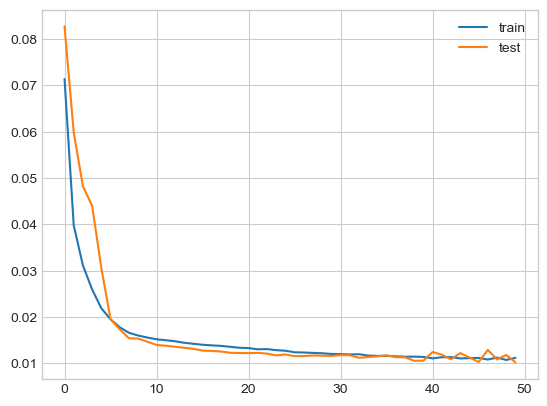

In [115]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mae')

In [116]:
LSTM_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adam_mae_metrics = ["Adam", "MAE"] + LSTM_adam_mae["metrics"]

297/297 [==============================] - 2s 3ms/step
Test MAE: 0.547
Test MSE: 0.533
Test RMSE: 0.730
Test R2: 0.992


##### Optimizer: Adam, Loss: MAPE

Epoch 1/50
240/240 - 12s - loss: 13.1121 - val_loss: 22.6692 - 12s/epoch - 48ms/step
Epoch 2/50
240/240 - 1s - loss: 9.8022 - val_loss: 16.6273 - 1s/epoch - 5ms/step
Epoch 3/50
240/240 - 1s - loss: 8.2963 - val_loss: 12.3292 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 1s - loss: 6.8985 - val_loss: 9.6465 - 1s/epoch - 5ms/step
Epoch 5/50
240/240 - 1s - loss: 5.7093 - val_loss: 9.7926 - 969ms/epoch - 4ms/step
Epoch 6/50
240/240 - 1s - loss: 5.0242 - val_loss: 7.8157 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 4.2957 - val_loss: 5.2546 - 938ms/epoch - 4ms/step
Epoch 8/50
240/240 - 1s - loss: 3.8923 - val_loss: 4.9697 - 1s/epoch - 5ms/step
Epoch 9/50
240/240 - 1s - loss: 3.7804 - val_loss: 4.5085 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 1s - loss: 3.6813 - val_loss: 4.6340 - 1s/epoch - 6ms/step
Epoch 11/50
240/240 - 1s - loss: 3.6174 - val_loss: 4.3372 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 1s - loss: 3.5088 - val_loss: 4.0243 - 1s/epoch - 5ms/step
Epoch 13/50
240/240 - 1s

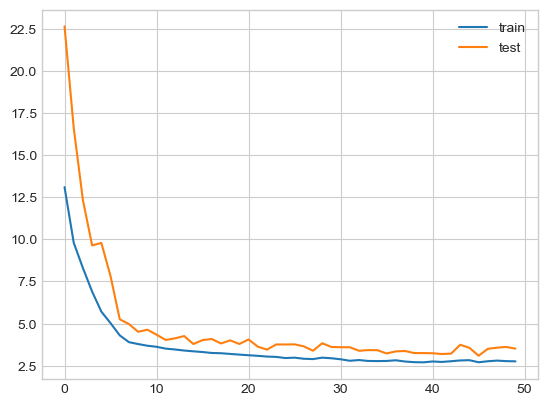

In [117]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mape')

In [118]:
LSTM_adam_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adam_mape_metrics = ["Adam", "MAPE"] + LSTM_adam_mape["metrics"]

297/297 [==============================] - 2s 3ms/step
Test MAE: 0.555
Test MSE: 0.552
Test RMSE: 0.743
Test R2: 0.992


##### Optimizer: SGD, Loss: MSE

Epoch 1/50
240/240 - 14s - loss: 0.0250 - val_loss: 0.0429 - 14s/epoch - 58ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0143 - val_loss: 0.0312 - 2s/epoch - 8ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0111 - val_loss: 0.0233 - 2s/epoch - 7ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0090 - val_loss: 0.0179 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0076 - val_loss: 0.0142 - 2s/epoch - 7ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0067 - val_loss: 0.0115 - 2s/epoch - 7ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0059 - val_loss: 0.0096 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 0.0054 - val_loss: 0.0082 - 2s/epoch - 7ms/step
Epoch 9/50
240/240 - 1s - loss: 0.0049 - val_loss: 0.0071 - 1s/epoch - 6ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0046 - val_loss: 0.0063 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 0.0042 - val_loss: 0.0056 - 1s/epoch - 6ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0039 - val_loss: 0.0051 - 2s/epoch - 8ms/step
Epoch 13/50
240/240 - 1s - loss: 0

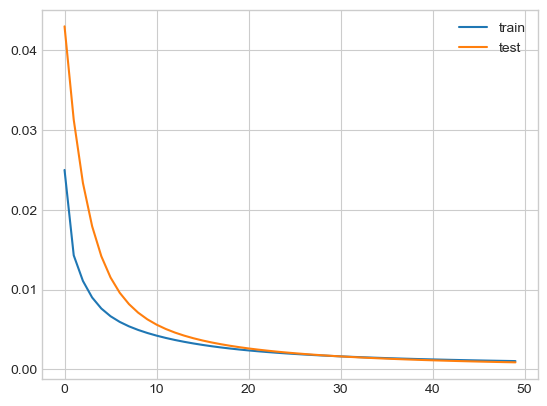

In [119]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'sgd', 'mse')

In [120]:
LSTM_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_sgd_mse_metrics = ["SGD", "MSE"] + LSTM_sgd_mse["metrics"]

297/297 [==============================] - 4s 4ms/step
Test MAE: 1.304
Test MSE: 2.703
Test RMSE: 1.644
Test R2: 0.959


##### Optimizer: SGD, Loss: MAE

Epoch 1/50
240/240 - 14s - loss: 0.0603 - val_loss: 0.1234 - 14s/epoch - 57ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0465 - val_loss: 0.0920 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0407 - val_loss: 0.0739 - 2s/epoch - 7ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0364 - val_loss: 0.0625 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0328 - val_loss: 0.0512 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0297 - val_loss: 0.0436 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0272 - val_loss: 0.0377 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0251 - val_loss: 0.0330 - 1s/epoch - 6ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0235 - val_loss: 0.0290 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0221 - val_loss: 0.0266 - 2s/epoch - 9ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0209 - val_loss: 0.0242 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0200 - val_loss: 0.0224 - 2s/epoch - 7ms/step
Epoch 13/50
240/240 - 2s - loss: 0

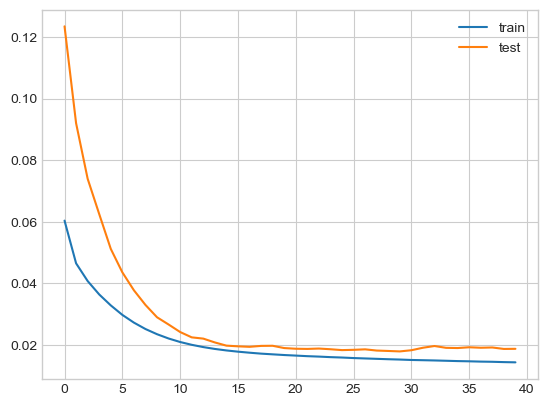

In [121]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'sgd', 'mae')

In [122]:
LSTM_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_sgd_mae_metrics = ["SGD", "MAE"] + LSTM_sgd_mae["metrics"]

297/297 [==============================] - 5s 5ms/step
Test MAE: 0.858
Test MSE: 1.166
Test RMSE: 1.080
Test R2: 0.982


##### Optimizer: SGD, Loss: MAPE

Epoch 1/50
240/240 - 15s - loss: 322.9040 - val_loss: 140.1719 - 15s/epoch - 62ms/step
Epoch 2/50
240/240 - 2s - loss: 310.4614 - val_loss: 243.3650 - 2s/epoch - 8ms/step
Epoch 3/50
240/240 - 2s - loss: 310.7124 - val_loss: 335.1538 - 2s/epoch - 7ms/step
Epoch 4/50
240/240 - 2s - loss: 315.0196 - val_loss: 293.1596 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 2s - loss: 312.4749 - val_loss: 266.2532 - 2s/epoch - 9ms/step
Epoch 6/50
240/240 - 2s - loss: 308.4919 - val_loss: 465.1961 - 2s/epoch - 8ms/step
Epoch 7/50
240/240 - 2s - loss: 313.6891 - val_loss: 317.9991 - 2s/epoch - 8ms/step
Epoch 8/50
240/240 - 2s - loss: 314.2309 - val_loss: 312.7061 - 2s/epoch - 7ms/step
Epoch 9/50
240/240 - 1s - loss: 313.9068 - val_loss: 165.2234 - 1s/epoch - 5ms/step
Epoch 10/50
240/240 - 2s - loss: 313.9404 - val_loss: 235.6277 - 2s/epoch - 6ms/step
Epoch 11/50
240/240 - 1s - loss: 314.0561 - val_loss: 406.7926 - 1s/epoch - 5ms/step


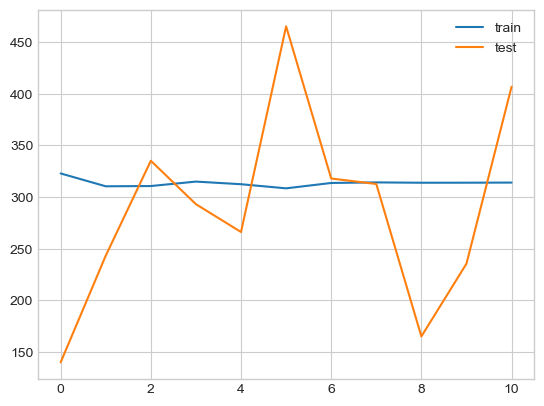

In [123]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'sgd', 'mape')

In [124]:
LSTM_sgd_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_sgd_mape_metrics = ["SGD", "MAPE"] + LSTM_sgd_mape["metrics"]

297/297 [==============================] - 3s 4ms/step
Test MAE: 16.914
Test MSE: 347.537
Test RMSE: 18.642
Test R2: -4.228


##### Optimizer: Adamax, Loss: MSE

Epoch 1/50
240/240 - 18s - loss: 0.0066 - val_loss: 0.0211 - 18s/epoch - 75ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0053 - val_loss: 0.0142 - 1s/epoch - 6ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0035 - val_loss: 0.0081 - 2s/epoch - 7ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0024 - val_loss: 0.0047 - 2s/epoch - 6ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0017 - val_loss: 0.0029 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0012 - val_loss: 0.0019 - 2s/epoch - 6ms/step
Epoch 7/50
240/240 - 2s - loss: 9.5347e-04 - val_loss: 0.0014 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 7.8615e-04 - val_loss: 0.0011 - 2s/epoch - 7ms/step
Epoch 9/50
240/240 - 2s - loss: 6.6459e-04 - val_loss: 7.8749e-04 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 5.7776e-04 - val_loss: 6.5759e-04 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 2s - loss: 5.2019e-04 - val_loss: 6.2660e-04 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 4.8287e-04 - val_loss: 5.8995e-04 - 2s/epoch - 8ms

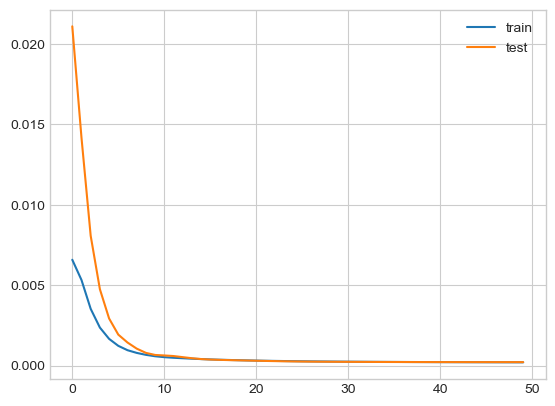

In [125]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adamax', 'mse')

In [126]:
LSTM_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adamax_mse_metrics = ["Adamax", "MSE"] + LSTM_adamax_mse["metrics"]

297/297 [==============================] - 5s 6ms/step
Test MAE: 0.581
Test MSE: 0.599
Test RMSE: 0.774
Test R2: 0.991


##### Optimizer: Adamax, Loss: MAE

Epoch 1/50
240/240 - 19s - loss: 0.0517 - val_loss: 0.0737 - 19s/epoch - 79ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0362 - val_loss: 0.0532 - 2s/epoch - 8ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0289 - val_loss: 0.0400 - 2s/epoch - 8ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0247 - val_loss: 0.0310 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0220 - val_loss: 0.0294 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0200 - val_loss: 0.0256 - 2s/epoch - 9ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0186 - val_loss: 0.0221 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 0.0176 - val_loss: 0.0205 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0168 - val_loss: 0.0180 - 2s/epoch - 9ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0162 - val_loss: 0.0170 - 2s/epoch - 8ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0157 - val_loss: 0.0170 - 2s/epoch - 9ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0153 - val_loss: 0.0160 - 2s/epoch - 8ms/step
Epoch 13/50
240/240 - 2s - loss: 0

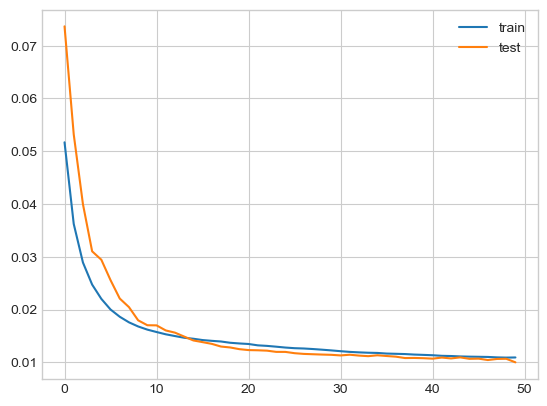

In [127]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adamax', 'mae')

In [128]:
LSTM_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adamax_mae_metrics = ["Adamax", "MAE"] + LSTM_adamax_mae["metrics"]

297/297 [==============================] - 5s 5ms/step
Test MAE: 0.602
Test MSE: 0.642
Test RMSE: 0.801
Test R2: 0.990


##### Optimizer: Adamax, Loss: MAPE

Epoch 1/50
240/240 - 21s - loss: 15.2456 - val_loss: 35.7062 - 21s/epoch - 88ms/step
Epoch 2/50
240/240 - 2s - loss: 11.4758 - val_loss: 19.6068 - 2s/epoch - 9ms/step
Epoch 3/50
240/240 - 2s - loss: 7.9608 - val_loss: 13.2466 - 2s/epoch - 9ms/step
Epoch 4/50
240/240 - 2s - loss: 6.1038 - val_loss: 9.1184 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 2s - loss: 5.1493 - val_loss: 6.7361 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 4.5410 - val_loss: 5.7044 - 2s/epoch - 8ms/step
Epoch 7/50
240/240 - 2s - loss: 4.1380 - val_loss: 5.2069 - 2s/epoch - 10ms/step
Epoch 8/50
240/240 - 2s - loss: 3.8733 - val_loss: 5.0666 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 3.7182 - val_loss: 4.4065 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 3.5790 - val_loss: 4.2084 - 2s/epoch - 9ms/step
Epoch 11/50
240/240 - 2s - loss: 3.4745 - val_loss: 4.0268 - 2s/epoch - 8ms/step
Epoch 12/50
240/240 - 2s - loss: 3.3673 - val_loss: 4.0255 - 2s/epoch - 8ms/step
Epoch 13/50
240/240 - 2s - l

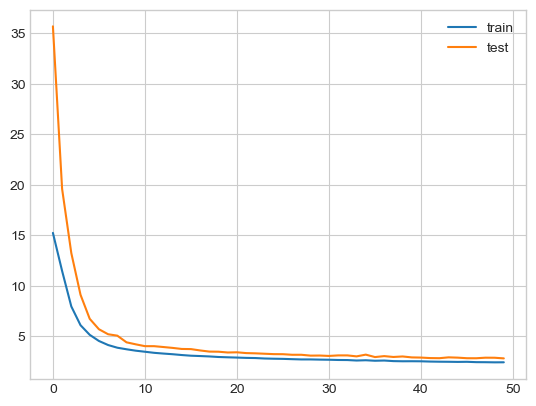

In [129]:
model = train_LSTM_model(prepared_data["train_X"], prepared_data["train_y"], prepared_data["val_X"], 
                         prepared_data["val_y"], 'adamax', 'mape')

In [130]:
LSTM_adamax_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                                                prepared_data["test_X"], prepared_data["test_y"])
LSTM_adamax_mape_metrics = ["Adamax", "MAPE"] + LSTM_adamax_mape["metrics"]

297/297 [==============================] - 3s 5ms/step
Test MAE: 0.574
Test MSE: 0.590
Test RMSE: 0.768
Test R2: 0.991


#### GRU

##### Optimizer: Adam, Loss: MSE

Epoch 1/50
240/240 - 11s - loss: 0.0031 - val_loss: 0.0019 - 11s/epoch - 46ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0011 - val_loss: 8.2729e-04 - 1s/epoch - 6ms/step
Epoch 3/50
240/240 - 1s - loss: 6.6975e-04 - val_loss: 6.1400e-04 - 1s/epoch - 6ms/step
Epoch 4/50
240/240 - 2s - loss: 5.5678e-04 - val_loss: 5.6055e-04 - 2s/epoch - 6ms/step
Epoch 5/50
240/240 - 1s - loss: 5.2845e-04 - val_loss: 5.4935e-04 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 1s - loss: 5.1751e-04 - val_loss: 5.0525e-04 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 1s - loss: 5.0563e-04 - val_loss: 4.7032e-04 - 1s/epoch - 6ms/step
Epoch 8/50
240/240 - 2s - loss: 4.9192e-04 - val_loss: 4.4653e-04 - 2s/epoch - 9ms/step
Epoch 9/50
240/240 - 2s - loss: 4.7586e-04 - val_loss: 4.2881e-04 - 2s/epoch - 8ms/step
Epoch 10/50
240/240 - 2s - loss: 4.5876e-04 - val_loss: 4.1449e-04 - 2s/epoch - 8ms/step
Epoch 11/50
240/240 - 2s - loss: 4.4230e-04 - val_loss: 4.0230e-04 - 2s/epoch - 8ms/step
Epoch 12/50
240/240 - 2s - loss: 4.2745

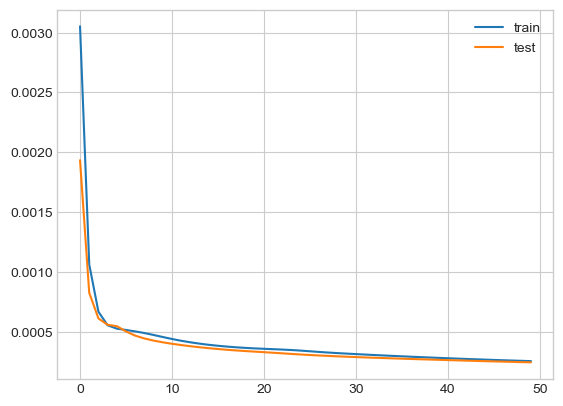

In [131]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mse')

In [132]:
GRU_adam_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adam_mse_metrics = ["Adam", "MSE"] + GRU_adam_mse["metrics"]

297/297 [==============================] - 4s 5ms/step
Test MAE: 0.615
Test MSE: 0.663
Test RMSE: 0.814
Test R2: 0.990


##### Optimizer: Adam, Loss: MAE

Epoch 1/50
240/240 - 15s - loss: 0.0632 - val_loss: 0.0741 - 15s/epoch - 62ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0323 - val_loss: 0.0257 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0243 - val_loss: 0.0244 - 2s/epoch - 8ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0204 - val_loss: 0.0172 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0197 - val_loss: 0.0163 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0189 - val_loss: 0.0146 - 2s/epoch - 8ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0172 - val_loss: 0.0150 - 2s/epoch - 8ms/step
Epoch 8/50
240/240 - 2s - loss: 0.0166 - val_loss: 0.0159 - 2s/epoch - 7ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0176 - val_loss: 0.0142 - 2s/epoch - 10ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0157 - val_loss: 0.0165 - 2s/epoch - 9ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0153 - val_loss: 0.0174 - 2s/epoch - 8ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0165 - val_loss: 0.0158 - 2s/epoch - 8ms/step
Epoch 13/50
240/240 - 2s - loss: 

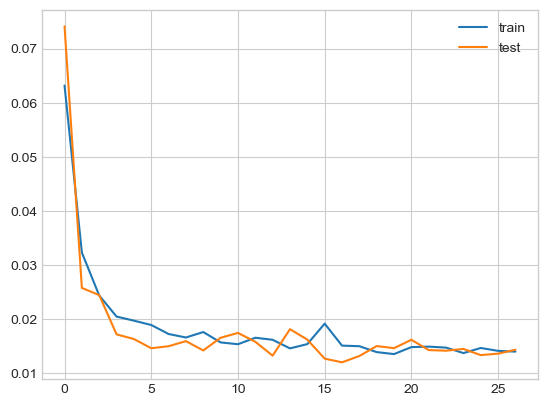

In [133]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mae')

In [134]:
GRU_adam_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adam_mae_metrics = ["Adam", "MAE"] + GRU_adam_mae["metrics"]

297/297 [==============================] - 4s 4ms/step
Test MAE: 0.706
Test MSE: 0.831
Test RMSE: 0.912
Test R2: 0.987


##### Optimizer: Adam, Loss: MAPE

Epoch 1/50
240/240 - 14s - loss: 19.0897 - val_loss: 25.9434 - 14s/epoch - 59ms/step
Epoch 2/50
240/240 - 2s - loss: 9.5150 - val_loss: 14.9547 - 2s/epoch - 7ms/step
Epoch 3/50
240/240 - 2s - loss: 5.9650 - val_loss: 4.6939 - 2s/epoch - 8ms/step
Epoch 4/50
240/240 - 2s - loss: 5.3820 - val_loss: 6.2019 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 2s - loss: 4.2465 - val_loss: 4.0001 - 2s/epoch - 9ms/step
Epoch 6/50
240/240 - 2s - loss: 4.6304 - val_loss: 4.1274 - 2s/epoch - 9ms/step
Epoch 7/50
240/240 - 2s - loss: 3.6873 - val_loss: 4.0294 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 3.7071 - val_loss: 5.3615 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 3.6398 - val_loss: 3.9533 - 2s/epoch - 8ms/step
Epoch 10/50
240/240 - 2s - loss: 3.5449 - val_loss: 5.1871 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 2s - loss: 3.6975 - val_loss: 5.1509 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 3.6180 - val_loss: 4.3956 - 2s/epoch - 8ms/step
Epoch 13/50
240/240 - 2s - loss

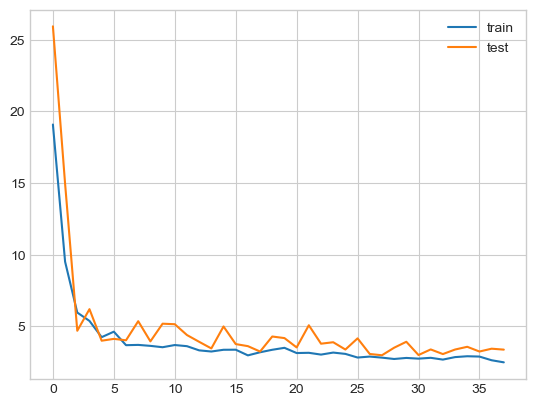

In [135]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adam', 'mape')

In [136]:
GRU_adam_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adam_mape_metrics = ["Adam", "MAPE"] + GRU_adam_mape["metrics"]

297/297 [==============================] - 4s 5ms/step
Test MAE: 0.588
Test MSE: 0.607
Test RMSE: 0.779
Test R2: 0.991


##### Optimizer: SGD, Loss: MSE

Epoch 1/50
240/240 - 14s - loss: 0.0154 - val_loss: 0.0388 - 14s/epoch - 58ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0068 - val_loss: 0.0178 - 2s/epoch - 8ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0044 - val_loss: 0.0101 - 2s/epoch - 9ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0034 - val_loss: 0.0067 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0029 - val_loss: 0.0049 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0025 - val_loss: 0.0038 - 2s/epoch - 9ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0022 - val_loss: 0.0031 - 1s/epoch - 6ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0020 - val_loss: 0.0026 - 1s/epoch - 5ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0018 - val_loss: 0.0022 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 1s - loss: 0.0017 - val_loss: 0.0019 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0016 - val_loss: 0.0017 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 1s - loss: 0.0015 - val_loss: 0.0016 - 1s/epoch - 5ms/step
Epoch 13/50
240/240 - 2s - loss: 0

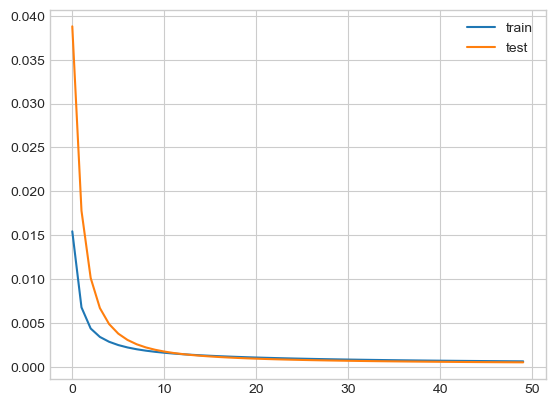

In [137]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'sgd', 'mse')

In [138]:
GRU_sgd_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_sgd_mse_metrics = ["SGD", "MSE"] + GRU_sgd_mse["metrics"]

297/297 [==============================] - 6s 5ms/step
Test MAE: 0.934
Test MSE: 1.411
Test RMSE: 1.188
Test R2: 0.979


##### Optimizer: SGD, Loss: MAE

Epoch 1/50
240/240 - 13s - loss: 0.0506 - val_loss: 0.0775 - 13s/epoch - 55ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0318 - val_loss: 0.0577 - 2s/epoch - 8ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0272 - val_loss: 0.0415 - 2s/epoch - 8ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0247 - val_loss: 0.0367 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0232 - val_loss: 0.0328 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0221 - val_loss: 0.0327 - 2s/epoch - 8ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0215 - val_loss: 0.0360 - 2s/epoch - 8ms/step
Epoch 8/50
240/240 - 2s - loss: 0.0207 - val_loss: 0.0332 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0206 - val_loss: 0.0325 - 2s/epoch - 7ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0205 - val_loss: 0.0378 - 2s/epoch - 9ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0202 - val_loss: 0.0320 - 2s/epoch - 8ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0200 - val_loss: 0.0347 - 2s/epoch - 7ms/step
Epoch 13/50
240/240 - 2s - loss: 0

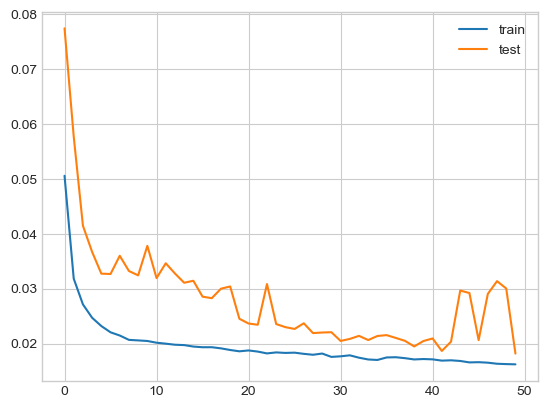

In [139]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'sgd', 'mae')

In [140]:
GRU_sgd_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_sgd_mae_metrics = ["SGD", "MAE"] + GRU_sgd_mae["metrics"]

297/297 [==============================] - 4s 4ms/step
Test MAE: 0.839
Test MSE: 1.119
Test RMSE: 1.058
Test R2: 0.983


##### Optimizer: SGD, Loss: MAPE

Epoch 1/50
240/240 - 12s - loss: 668.6325 - val_loss: 598.6617 - 12s/epoch - 52ms/step
Epoch 2/50
240/240 - 2s - loss: 631.5895 - val_loss: 664.0643 - 2s/epoch - 8ms/step
Epoch 3/50
240/240 - 2s - loss: 630.4231 - val_loss: 699.9777 - 2s/epoch - 9ms/step
Epoch 4/50
240/240 - 2s - loss: 624.1077 - val_loss: 545.0587 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 1s - loss: 629.8242 - val_loss: 616.6083 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 2s - loss: 613.9418 - val_loss: 273.9871 - 2s/epoch - 8ms/step
Epoch 7/50
240/240 - 2s - loss: 629.7370 - val_loss: 558.9078 - 2s/epoch - 9ms/step
Epoch 8/50
240/240 - 2s - loss: 625.7919 - val_loss: 653.9075 - 2s/epoch - 7ms/step
Epoch 9/50
240/240 - 2s - loss: 631.1082 - val_loss: 611.0511 - 2s/epoch - 8ms/step
Epoch 10/50
240/240 - 2s - loss: 628.4069 - val_loss: 630.8837 - 2s/epoch - 7ms/step
Epoch 11/50
240/240 - 2s - loss: 480.9424 - val_loss: 290.2172 - 2s/epoch - 9ms/step
Epoch 12/50
240/240 - 1s - loss: 313.2610 - val_loss: 215.7087 - 1s/epo

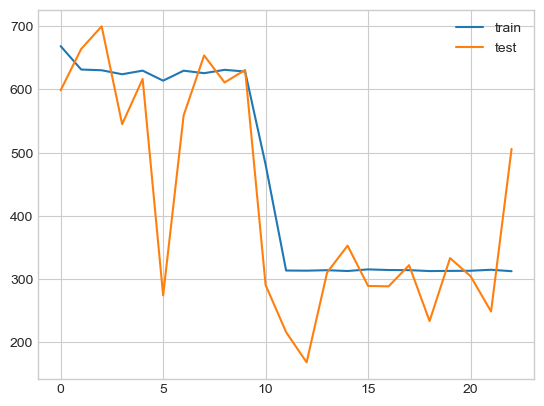

In [141]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'sgd', 'mape')

In [142]:
GRU_sgd_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_sgd_mape_metrics = ["SGD", "MAPE"] + GRU_sgd_mape["metrics"]

297/297 [==============================] - 3s 4ms/step
Test MAE: 32.313
Test MSE: 1112.129
Test RMSE: 33.349
Test R2: -15.730


##### Optimizer: Adamax, Loss: MSE

Epoch 1/50
240/240 - 11s - loss: 0.0058 - val_loss: 0.0098 - 11s/epoch - 45ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0033 - val_loss: 0.0053 - 1s/epoch - 5ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0020 - val_loss: 0.0032 - 2s/epoch - 7ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0013 - val_loss: 0.0021 - 2s/epoch - 7ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0010 - val_loss: 0.0013 - 2s/epoch - 7ms/step
Epoch 6/50
240/240 - 1s - loss: 8.0696e-04 - val_loss: 0.0010 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 2s - loss: 6.9810e-04 - val_loss: 8.8718e-04 - 2s/epoch - 7ms/step
Epoch 8/50
240/240 - 2s - loss: 6.3569e-04 - val_loss: 7.2684e-04 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 5.6696e-04 - val_loss: 5.8205e-04 - 2s/epoch - 8ms/step
Epoch 10/50
240/240 - 1s - loss: 5.0957e-04 - val_loss: 5.0214e-04 - 917ms/epoch - 4ms/step
Epoch 11/50
240/240 - 2s - loss: 4.7115e-04 - val_loss: 4.5050e-04 - 2s/epoch - 7ms/step
Epoch 12/50
240/240 - 2s - loss: 4.3153e-04 - val_loss: 4.0741e-04 -

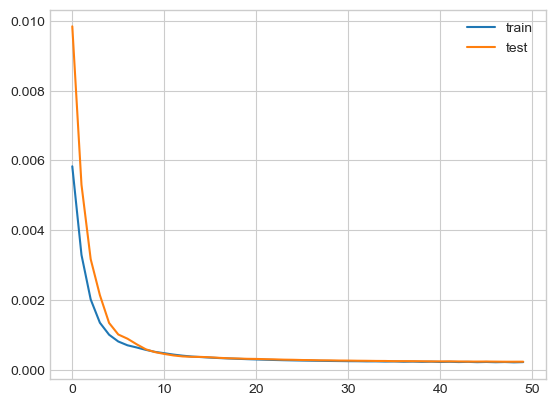

In [143]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mse')

In [144]:
GRU_adamax_mse = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adamax_mse_metrics = ["Adamax", "MSE"] + GRU_adamax_mse["metrics"]

297/297 [==============================] - 4s 6ms/step
Test MAE: 0.592
Test MSE: 0.616
Test RMSE: 0.785
Test R2: 0.991


##### Optimizer: Adamax, Loss: MAE

Epoch 1/50
240/240 - 14s - loss: 0.0596 - val_loss: 0.0811 - 14s/epoch - 58ms/step
Epoch 2/50
240/240 - 2s - loss: 0.0397 - val_loss: 0.0542 - 2s/epoch - 9ms/step
Epoch 3/50
240/240 - 2s - loss: 0.0292 - val_loss: 0.0427 - 2s/epoch - 7ms/step
Epoch 4/50
240/240 - 2s - loss: 0.0234 - val_loss: 0.0361 - 2s/epoch - 8ms/step
Epoch 5/50
240/240 - 2s - loss: 0.0205 - val_loss: 0.0269 - 2s/epoch - 9ms/step
Epoch 6/50
240/240 - 2s - loss: 0.0185 - val_loss: 0.0180 - 2s/epoch - 8ms/step
Epoch 7/50
240/240 - 2s - loss: 0.0171 - val_loss: 0.0160 - 2s/epoch - 9ms/step
Epoch 8/50
240/240 - 2s - loss: 0.0163 - val_loss: 0.0165 - 2s/epoch - 8ms/step
Epoch 9/50
240/240 - 2s - loss: 0.0159 - val_loss: 0.0155 - 2s/epoch - 8ms/step
Epoch 10/50
240/240 - 2s - loss: 0.0149 - val_loss: 0.0151 - 2s/epoch - 9ms/step
Epoch 11/50
240/240 - 2s - loss: 0.0146 - val_loss: 0.0147 - 2s/epoch - 9ms/step
Epoch 12/50
240/240 - 2s - loss: 0.0142 - val_loss: 0.0139 - 2s/epoch - 9ms/step
Epoch 13/50
240/240 - 2s - loss: 0

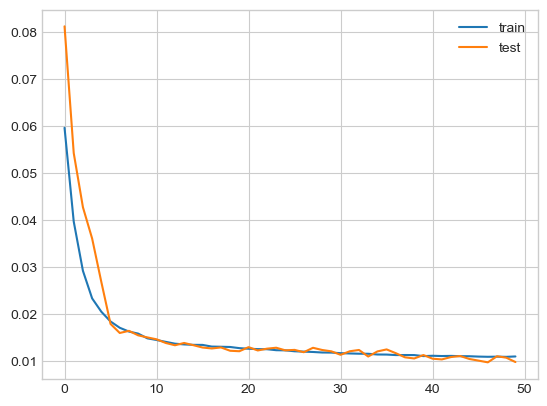

In [145]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mae')

In [146]:
GRU_adamax_mae = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adamax_mae_metrics = ["Adamax", "MAE"] + GRU_adamax_mae["metrics"]

297/297 [==============================] - 4s 5ms/step
Test MAE: 0.532
Test MSE: 0.530
Test RMSE: 0.728
Test R2: 0.992


##### Optimizer: Adamax, Loss: MAPE

Epoch 1/50
240/240 - 17s - loss: 11.0837 - val_loss: 13.9754 - 17s/epoch - 70ms/step
Epoch 2/50
240/240 - 2s - loss: 6.5812 - val_loss: 8.2023 - 2s/epoch - 9ms/step
Epoch 3/50
240/240 - 2s - loss: 5.2930 - val_loss: 7.5053 - 2s/epoch - 8ms/step
Epoch 4/50
240/240 - 2s - loss: 4.7055 - val_loss: 6.3472 - 2s/epoch - 9ms/step
Epoch 5/50
240/240 - 2s - loss: 4.1957 - val_loss: 5.3803 - 2s/epoch - 8ms/step
Epoch 6/50
240/240 - 2s - loss: 3.9750 - val_loss: 4.7495 - 2s/epoch - 9ms/step
Epoch 7/50
240/240 - 2s - loss: 3.8222 - val_loss: 4.3953 - 2s/epoch - 9ms/step
Epoch 8/50
240/240 - 2s - loss: 3.7102 - val_loss: 4.3194 - 2s/epoch - 9ms/step
Epoch 9/50
240/240 - 2s - loss: 3.6125 - val_loss: 4.1319 - 2s/epoch - 10ms/step
Epoch 10/50
240/240 - 2s - loss: 3.4924 - val_loss: 3.9749 - 2s/epoch - 9ms/step
Epoch 11/50
240/240 - 2s - loss: 3.3930 - val_loss: 3.9164 - 2s/epoch - 9ms/step
Epoch 12/50
240/240 - 2s - loss: 3.3283 - val_loss: 3.9262 - 2s/epoch - 8ms/step
Epoch 13/50
240/240 - 2s - loss

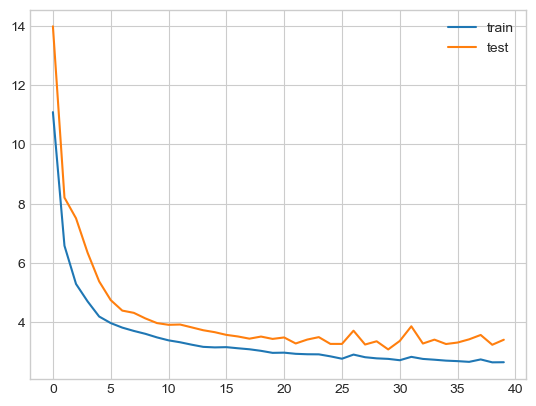

In [147]:
model = train_GRU_model(prepared_data["train_X"], prepared_data["train_y"], 
                        prepared_data["val_X"], prepared_data["val_y"], 'adamax', 'mape')

In [148]:
GRU_adamax_mape = evaluate_model(model, prepared_data["values_min"], prepared_data["values_max"],
                                                            prepared_data["test_X"], prepared_data["test_y"])
GRU_adamax_mape_metrics = ["Adamax", "MAPE"] + GRU_adamax_mape["metrics"]

297/297 [==============================] - 4s 6ms/step
Test MAE: 0.586
Test MSE: 0.611
Test RMSE: 0.782
Test R2: 0.991


#### Results

In [149]:
columns = ["OPTIMIZER", "LOSS", "MAE", "MSE", "RMSE", "R2"]
indexes = []
values = []

simpleRNN_res = [simpleRNN_adam_mse_metrics, simpleRNN_adam_mae_metrics, simpleRNN_adam_mape_metrics, 
                 simpleRNN_sgd_mse_metrics, simpleRNN_sgd_mae_metrics, simpleRNN_sgd_mape_metrics, 
                 simpleRNN_adamax_mse_metrics, simpleRNN_adamax_mae_metrics, simpleRNN_adamax_mape_metrics]
LSTM_res = [LSTM_adam_mse_metrics, LSTM_adam_mae_metrics, LSTM_adam_mape_metrics, 
            LSTM_sgd_mse_metrics, LSTM_sgd_mae_metrics, LSTM_sgd_mape_metrics,
            LSTM_adamax_mse_metrics, LSTM_adamax_mae_metrics, LSTM_adamax_mape_metrics]
GRU_res = [GRU_adam_mse_metrics, GRU_adam_mae_metrics, GRU_adam_mape_metrics,
           GRU_sgd_mse_metrics, GRU_sgd_mae_metrics, GRU_sgd_mape_metrics, 
           GRU_adamax_mse_metrics, GRU_adamax_mae_metrics, GRU_adamax_mape_metrics]

for r in simpleRNN_res:
    indexes.append("Simple RNN")
    values.append(r)
for r in LSTM_res:
    indexes.append("LSTM")
    values.append(r)
for r in GRU_res:
    indexes.append("GRU")
    values.append(r)

multivariate_res = pd.DataFrame(values, columns=columns)
multivariate_res.index = indexes

In [150]:
multivariate_res

OPTIMIZER  LOSS          MAE           MSE         RMSE  \
Simple RNN      Adam   MSE     0.719172  8.668042e-01     0.931023   
Simple RNN      Adam   MAE     0.668950  7.416238e-01     0.861176   
Simple RNN      Adam  MAPE     0.608322  6.627841e-01     0.814116   
Simple RNN       SGD   MSE     0.878249  1.294017e+00     1.137549   
Simple RNN       SGD   MAE     1.819002  5.171331e+00     2.274056   
Simple RNN       SGD  MAPE  2276.275877  5.210727e+06  2282.701685   
Simple RNN    Adamax   MSE     0.602698  6.502252e-01     0.806365   
Simple RNN    Adamax   MAE     0.617744  6.992003e-01     0.836182   
Simple RNN    Adamax  MAPE     0.625373  6.771984e-01     0.822921   
LSTM            Adam   MSE     0.621879  6.689281e-01     0.817880   
LSTM            Adam   MAE     0.547015  5.325389e-01     0.729753   
LSTM            Adam  MAPE     0.554965  5.515274e-01     0.742649   
LSTM             SGD   MSE     1.303624  2.702757e+00     1.644006   
LSTM             SGD   MAE     0.858453  1.165647e+00     1.079651   
LSTM             SGD  MAPE    16.913626  3.475374e+02    18.642354   
LSTM          Adamax   MSE     0.580923  5.991390e-01     0.774041   
LSTM          Adamax   MAE     0.601837  6.420841e-01     0.801302   
LSTM          Adamax  MAPE     0.573840  5.904220e-01     0.768389   
GRU             Adam   MSE     0.614682  6.632078e-01     0.814376   
GRU             Adam   MAE     0.705762  8.312068e-01     0.911705   
GRU             Adam  MAPE     0.587560  6.070165e-01     0.779113   
GRU              SGD   MSE     0.933594  1.411380e+00     1.188015   
GRU              SGD   MAE     0.839283  1.118854e+00     1.057759   
GRU              SGD  MAPE    32.312534  1.112129e+03    33.348598   
GRU           Adamax   MSE     0.592116  6.164722e-01     0.785157   
GRU           Adamax   MAE     0.531914  5.295893e-01     0.727729   
GRU           Adamax  MAPE     0.585506  6.110821e-01     0.781717   

                      R2  
Simple RNN      0.986960  
Simple RNN      0.988843  
Simple RNN      0.990029  
Simple RNN      0.980533  
Simple RNN      0.922205  
Simple RNN -78386.725605  
Simple RNN      0.990218  
Simple RNN      0.989482  
Simple RNN      0.989813  
LSTM            0.989937  
LSTM            0.991989  
LSTM            0.991703  
LSTM            0.959341  
LSTM            0.982465  
LSTM           -4.228188  
LSTM            0.990987  
LSTM            0.990341  
LSTM            0.991118  
GRU             0.990023  
GRU             0.987496  
GRU             0.990868  
GRU             0.978768  
GRU             0.983168  
GRU           -15.730345  
GRU             0.990726  
GRU             0.992033  
GRU             0.990807

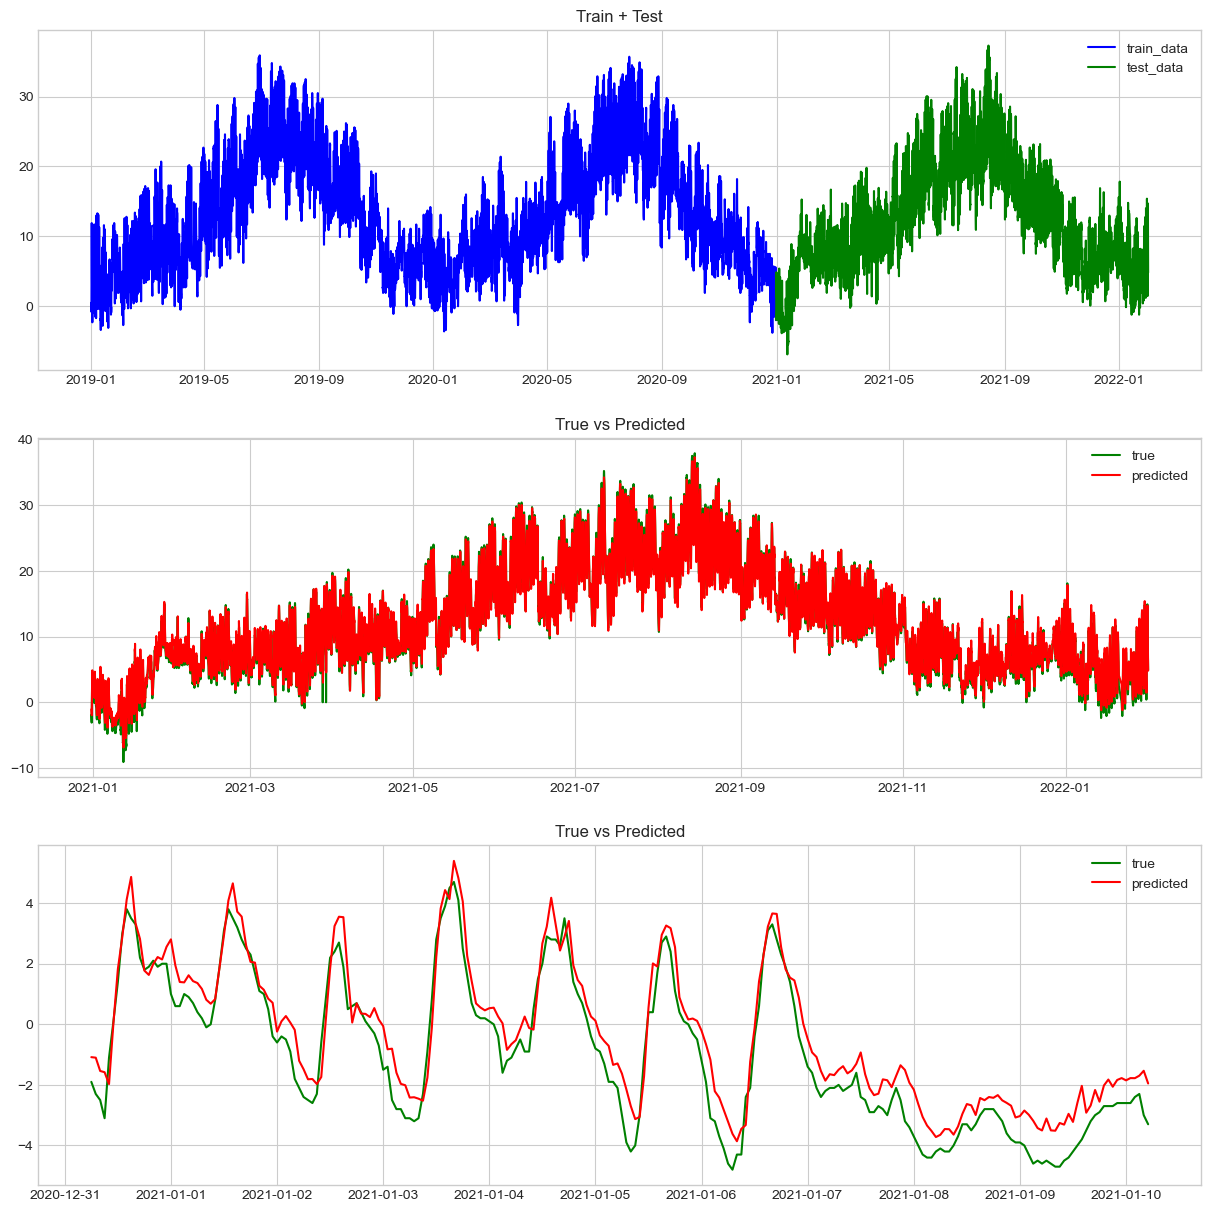

In [151]:
visualize_predictions(reframed.index, prepared_data["n_train_hours"], prepared_data["inv_train_y"], LSTM_adamax_mse["inv_y"], LSTM_adamax_mse["inv_pred_y"])